# Agricultural Product Distribution Forecasting

## Predicting Demand to Optimize Harvest Schedules and Distribution

### Import packages

All the packages needed for this project will be imported in this section.

In [1]:
import pandas as pd # For data manipulation
import numpy as np # For mathematical/numerical computations
from scipy import stats # For statistics
import matplotlib.pyplot as plt # For visualization
import seaborn as sns # For visualization
from statsmodels.tsa.stattools import adfuller # For stationarity check/test
from statsmodels.tsa.arima.model import ARIMA # For building ARIMA model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # For plotting ACF and PACF plot for ARIMA
from prophet import Prophet # For building Prophet model
from sklearn.ensemble import RandomForestRegressor # For building a forecasting model
from sklearn.metrics import (mean_absolute_error,  # Evaluation metrics
                             mean_absolute_percentage_error,
                             mean_squared_error)


import warnings
warnings.filterwarnings('ignore')

### Data Collection

The dataset will be brought into Python with pandas.

In [2]:
df = pd.read_csv('Dataset.csv')

### Data Exploration and Understanding

In this section, we will be spending time on the dataset in order to understand the basics of the data. We will focus on reviewing the contents, patterns, features, and even the relationship between these features.

Some of the things we'll be doing in this section includes:
- understanding the basic statistics like mean, median, standard deviation, etc of the dataset; this will help us know the values in our dataset is distributed,
- check for missing values and handle them if there are; this ensures that when we are performing some manipulations on the dataset later on, we're not going to run into errors that occur because of missing values, such as TypeError and ValueError,
- perform visualizations to show patterns, seasonality and trends; this is important because it also helps us to understand our dataset,
- check for correlations, so that we can see which features tend to affect sales, and its quantity,
- perform univariate, bivariate, multivariate and temporal analysis.

**NOTE**: We will not be removing duplicates here, because it is possible two eaual transactions to happen on the same day from the same customer. So, if we try to remove duplicate data, we may just cause problems for ourselves by removing relevant data.

See the first five rows of the data, to get a glimpse of its content.

In [3]:
df.head(5)

Date       Product  Quantity_Sold      Revenue  Temperature_Celsius  \
0  01/01/2015  Strawberries          690.0    70.298339             9.680289   
1  01/01/2015        Apples          354.0   599.863944             9.680289   
2  01/01/2015      Tomatoes          275.0   199.249505             9.680289   
3  01/01/2015        Apples         1079.0  1136.111770             9.680289   
4  01/01/2015  Strawberries         1008.0   111.653303             9.680289   

   Rainfall_mm Location  Transportation_Cost  Labor_Cost    Customer  \
0     0.077279  Field C                   20   13.771809  Customer B   
1     0.077279  Field A                   50    9.702670  Customer C   
2     0.077279  Field C                   20   22.356498  Customer C   
3     0.077279  Field A                   50   15.691418  Customer A   
4     0.077279  Field B                   30   17.473353  Customer B   

   Quality_Score  Inventory_Level  
0       0.769340           3608.0  
1       0.861953           3982.0  
2       0.861953           3708.0  
3       0.876056           3455.0  
4       0.769340           1504.0

A brief description of what the dataset's features represent:

- `Date`: Date of sale of product, which includes the day, month and year.
- `Product`: The name of the agricultural product, which includes Apples, Strawberries, Carrots and others.
- `Quantity_Sold`: The quantity of the agricultural product sold for that particular date.
- `Revenue`: Total revenue from the sale of the agricultural product in US dollars.
- `Temperature_Celsius`: The average temperature for the day in degree Celsius.
- `Rainfall_mm`: The amount of rainfall for that date, at the farm location in mm.
- `Location`: This denotes the specific location or field where an agricultural product was harvested.
- `Transportation_Cost`: The total cost of transportation from storage to the buyer.
- `Labor_Cost`: The estimated cost of producing that amount or quantity of produce.
- `Customer`: Anonymized ID of the particular customer that bought the agricultural product.
- `Quality_Score`: This measures the quality of the product. This measure if calculated using a variety of metrics, including the weight of the product, the whether or not there are defects, ripeness, sweetness, etc. It is a value between `0` and `1`.
- `Inventory_Level`: The quantity of that particular agricultural produce in stock  for that day.



Get a descriptive statistics of the numerical columns from the dataset, to understand how the values are distributed, including the mean, median, standard deviation and other parameters.

In [4]:
df.describe()

Quantity_Sold       Revenue  Temperature_Celsius   Rainfall_mm  \
count   28382.000000  28388.000000         28377.000000  28377.000000   
mean      609.197097    405.584444            20.024600      7.393332   
std       316.521726    485.206130             8.701719      4.316396   
min        41.000000      3.546003             5.011709      0.003963   
25%       334.000000     94.572138            12.435564      3.621238   
50%       607.500000    256.513966            20.124216      7.358936   
75%       884.000000    513.624224            27.544882     11.062843   
max      1195.000000   3382.034941            34.985404     14.997572   

       Transportation_Cost    Labor_Cost  Quality_Score  Inventory_Level  
count         28388.000000  28388.000000   28388.000000     28382.000000  
mean             33.465901     17.573430       0.835909      2617.164012  
std              12.466448      7.232465       0.047362      1189.840946  
min              20.000000      5.000083       0.769340        66.000000  
25%              20.000000     11.289710       0.769340      1621.000000  
50%              30.000000     17.586134       0.861953      2630.000000  
75%              50.000000     23.869033       0.876056      3597.000000  
max              50.000000     29.998989       0.876056      5172.000000

From this statistic, a few things can be observed:
- `count`: This indicates the number of non missing values in each column, the disparity between the 'count' values will be discussed later, it may indicate that there are missing values in some rows.
- `min`: This indicates the minimum value in each of these columns.
    - Hence the minimum quantity sold for any product at a particular time is `41`.
    - The minimum temperature from the dataset is `5.01` degree Celsius.
- `max`: This indicates the maximum value in each of these columns.
    - Hence the maximum quantity sold for any product at a particular time is `1195`.
    - The maximum temperature from the dataset is `34.99` degree Celsius.
- `mean`: Indicates the average value accross all values in a column. The mean `Quality_Score` of `0.835` indicates that most products were really good.
- `std`: Shows the spread of each column in the dataset.

Confirm the presence of missing values, and handle them if there are.

In [5]:
missing_values = df.isnull().sum()

missing_values

Date                    0
Product                 0
Quantity_Sold           6
Revenue                 0
Temperature_Celsius    11
Rainfall_mm            11
Location                0
Transportation_Cost     0
Labor_Cost              0
Customer                0
Quality_Score           0
Inventory_Level         6
dtype: int64

As seen from the result,
- `Quantity_Sold` has 6 missing values,
- `Temperature_Celsius` has 11 missing values,
- `Rainfall_mm` has 11 missing values.
- `Inventory_Level` has 6 missing values.

A few things to note about handling missing values are:
- if there are too many missing values in a column when compared to the number of rows in that column, it's usually best to drop the column.
- if there are a few missing values in a column when compared to the number of rows in the column, it can be OK to just fill in the missing values using different methods. For numerical columns, filling with the mean or median of the other values in the column is the most common approach.

In our case, the number of missing values `6` and `11` are really insignificant when compared to othe number of rows in the dataset (`28388` values), hence it is best to just fill in these values.

There are different methods of filling in missing values, and the method you use is going to be dependent on the type on a lot of things like:
- whether or not there are outliers,
- whether or not the data is skewed,
- whether the data is categorical or not,
- whether there is a correlation between the missing value and other variables in the dataset,
- whether or not there is a pattern to the missing values.

Since the `Quantity_Sold`, `Temperature_Celsius`, `Rainfall_mm` and `Inventory_Level` columns are not categorical variables, we will be testing to see if there are outliers. And we will be doing this by checking for the `zscore`. Any datapoint with an absolute `zscore` of above 3 is usually considered an outlier.

In [6]:
# List columns to check for
cols = ('Quantity_Sold', 'Temperature_Celsius', 'Rainfall_mm', 'Inventory_Level')

# Loop through the columns
for col in cols:

    # Check for outliers
    z = np.abs(stats.zscore(df[col], nan_policy='omit'))

    # See number of outliers
    outliers = df[z>3]
    print(f'{col} has {len(outliers)} outliers')

Quantity_Sold has 0 outliers
Temperature_Celsius has 0 outliers
Rainfall_mm has 0 outliers
Inventory_Level has 0 outliers


Since we have no outliers, we will go ahead to check for skewness. If the data in each of the columns is not skewed, the skewness should be very close to zero for each column.

In [7]:
# Loop through the columns
for col in cols:

    # Check for skewness
    skew = df[col].skew()
    print(f'{col} has a skewness of {skew}')

Quantity_Sold has a skewness of 0.007049968334628765
Temperature_Celsius has a skewness of -0.0052446336018828164
Rainfall_mm has a skewness of 0.017580193040890726
Inventory_Level has a skewness of -0.006928239182168006


Since we have conformed that the data in each of these columns have no outliers, and the data is not skewed, we can go ahead to fill in the missing values with the mean of the columns.

In [8]:
# Fill in missing values with the mean
df['Quantity_Sold'].fillna(df['Quantity_Sold'].mean(), inplace=True)
df['Temperature_Celsius'].fillna(df['Temperature_Celsius'].mean(), inplace=True)
df['Rainfall_mm'].fillna(df['Rainfall_mm'].mean(), inplace=True)
df['Inventory_Level'].fillna(df['Inventory_Level'].mean(), inplace=True)

Confirm that there are no more missing values.

In [9]:
missing_values = df.isnull().sum()

missing_values

Date                   0
Product                0
Quantity_Sold          0
Revenue                0
Temperature_Celsius    0
Rainfall_mm            0
Location               0
Transportation_Cost    0
Labor_Cost             0
Customer               0
Quality_Score          0
Inventory_Level        0
dtype: int64

All missing values have been handled.

Next, we're going to see if there are relationships between some of the variables, by showing some visualizations. We're going to be performing a variety of analysis, which include:
- Univariate Analysis,
- Bivariate Analysis,
- Multivariate Analysis, and
- Temporal Analysis.

#### Univariate Analysis

Here we will be analyzing the distribution of the variables individually, make different plots to see the distributions, and evaluate statistical measures like mean, median, standard deviation. We will approach this by analysing:
- numerical variables first,
- categorical variables second.

##### Univariate Analysis: Numerical Variables

We will begin by analysing the numerical variables here.

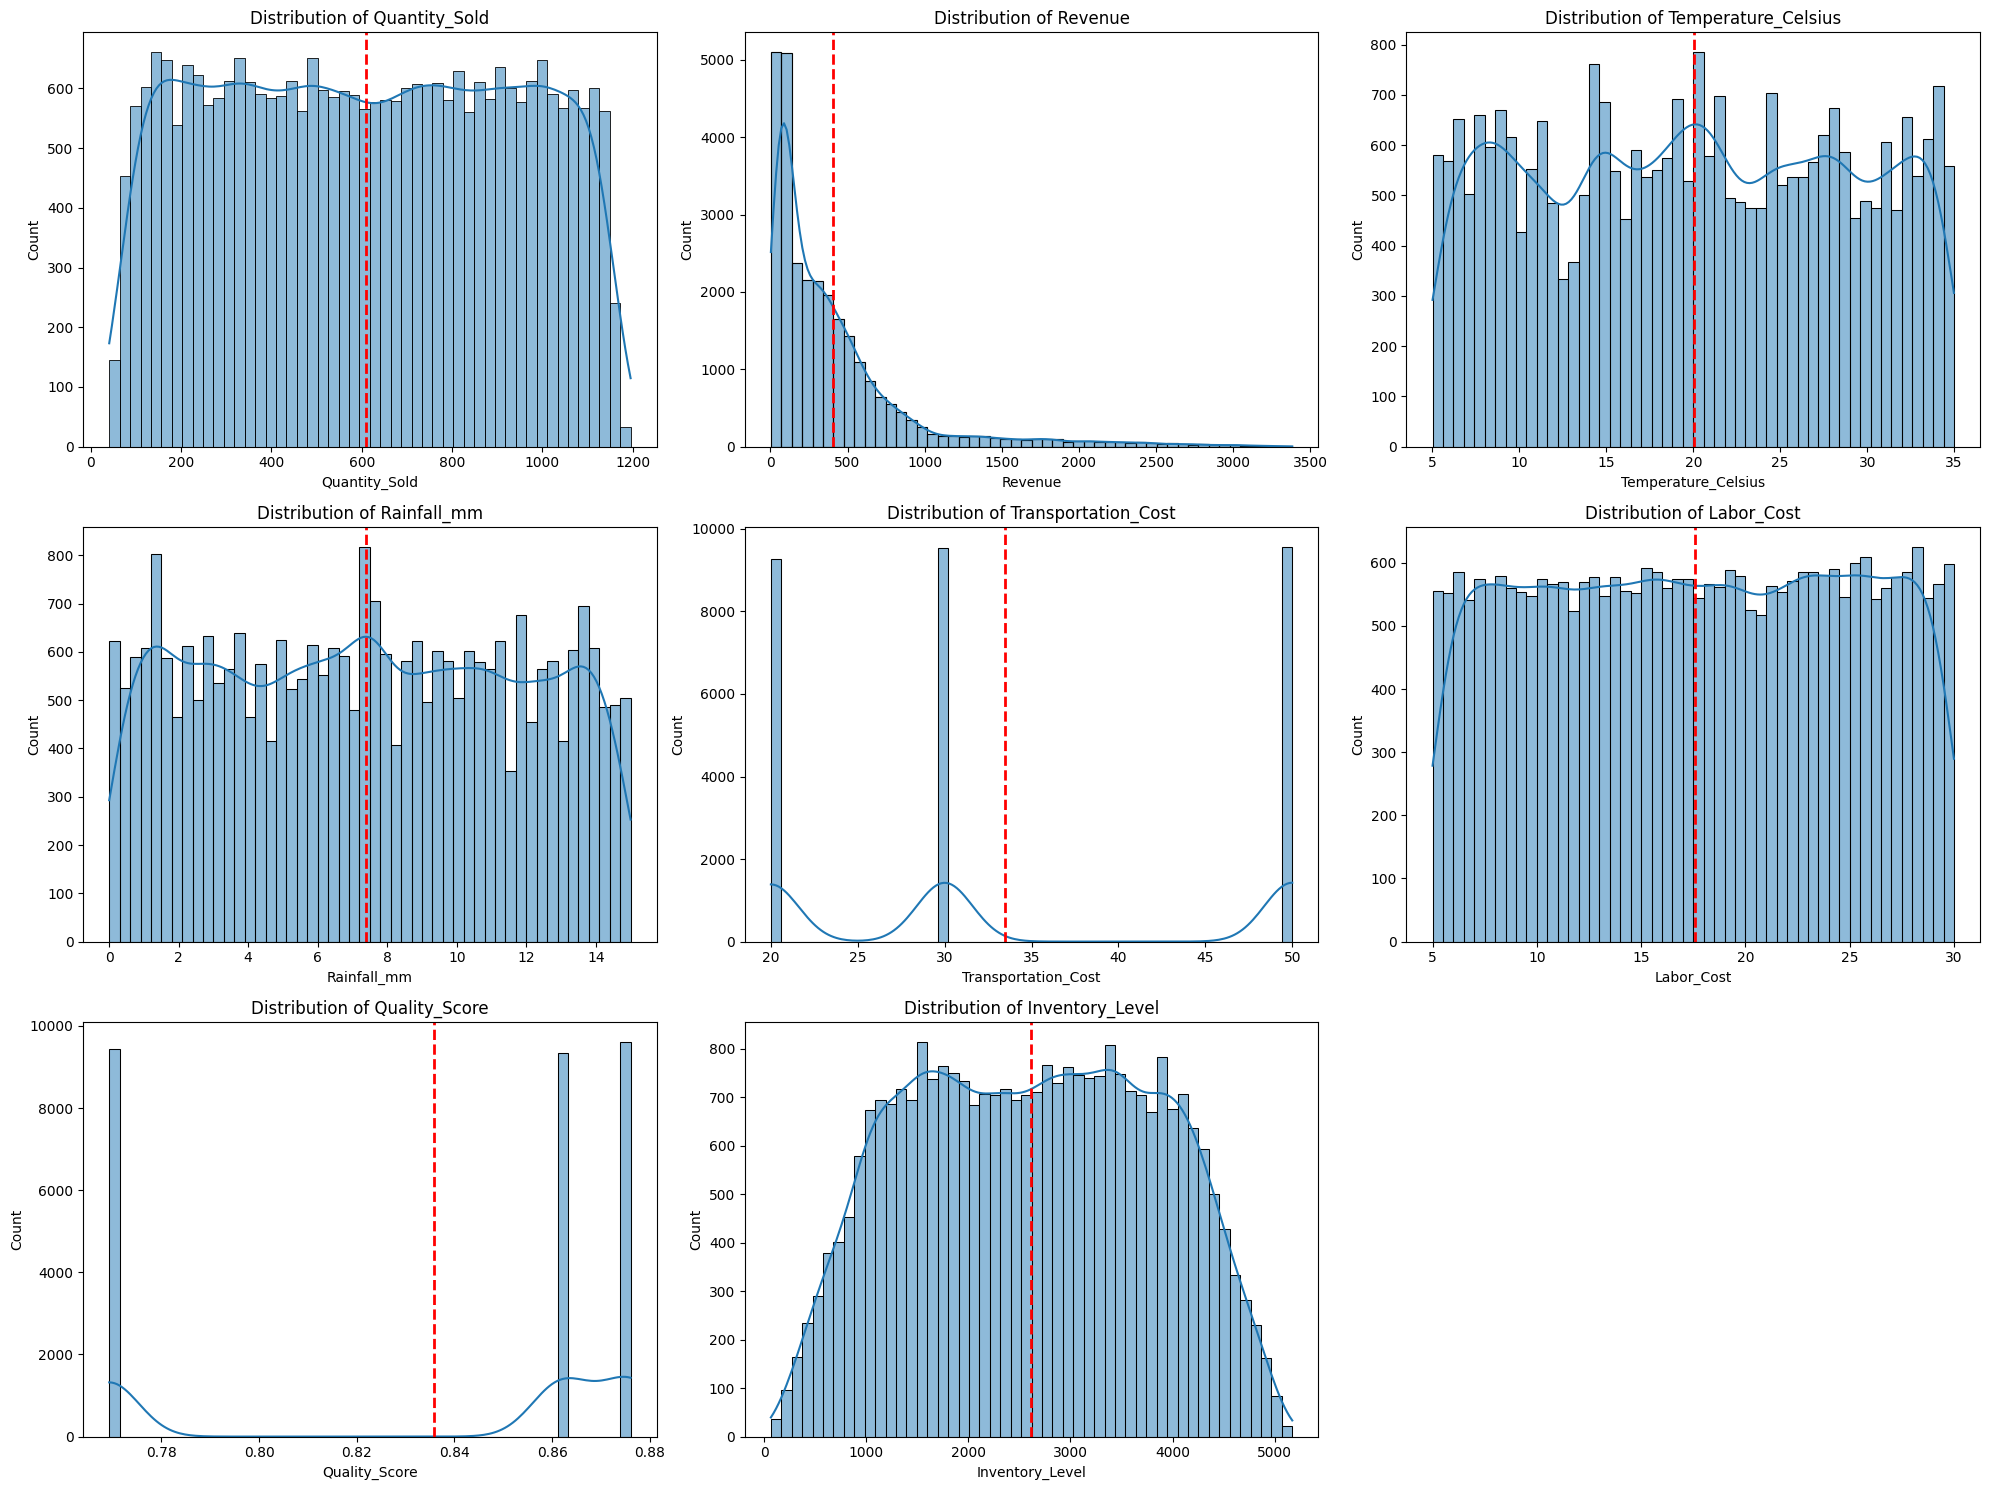

In [10]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# Plotting histograms for numeric variables
numeric_vars = ['Quantity_Sold',
                'Revenue',
                'Temperature_Celsius',
                'Rainfall_mm',
                'Transportation_Cost',
                'Labor_Cost',
                'Quality_Score',
                'Inventory_Level']

for i, var in enumerate(numeric_vars, 1):
    plt.subplot(3, 3, i)

    # Make histogram plot
    sns.histplot(df[var], bins=50, kde=True)

    # Plot the mean value for each
    plt.axvline(df[var].mean(), color='red', linestyle='dashed', linewidth=2)

    plt.title(f'Distribution of {var}')
    plt.tight_layout()

plt.show()

From the plots we just saw (the red line indicates the mean), a few things to note:
- `Quantity_Sold`: A lot of the values range between 400 and 700, wit a very few of the values going below 300, this suggests that the customers tend to buy within this range.
- `Revenue`: The revenue generated per sale are more within the range of $0 to $1,000. A few times, the revenue per sale goes up to $3,000.
- `Temperature_Celsius`: The temperature varies between 300 and 800 degree Celsius.
- `Rainfall_mm`: The amount of rainfall falls between the range of 300 to 800.
- `Transportation_Cost`: The transporation cost seem to clustered around three values (~20, ~30, ~50).
- `Labor_Cost`: Labor cost seems to have a roughly uniform distribution, and the values range between 500 and 600.
- `Quality_Score`: The quality score is distributed around some values as seen, a majority of the values hover around 0.77, 0.86 and 0.87.
- `Inventory_Level`: Most of the inventory levels seem to fall between ~1,000 and ~4,500. It also go as low as below 100 sometimes.

##### Univariate Analysis: Categorical Variables

We will now move over to analysing the categorical variables next.

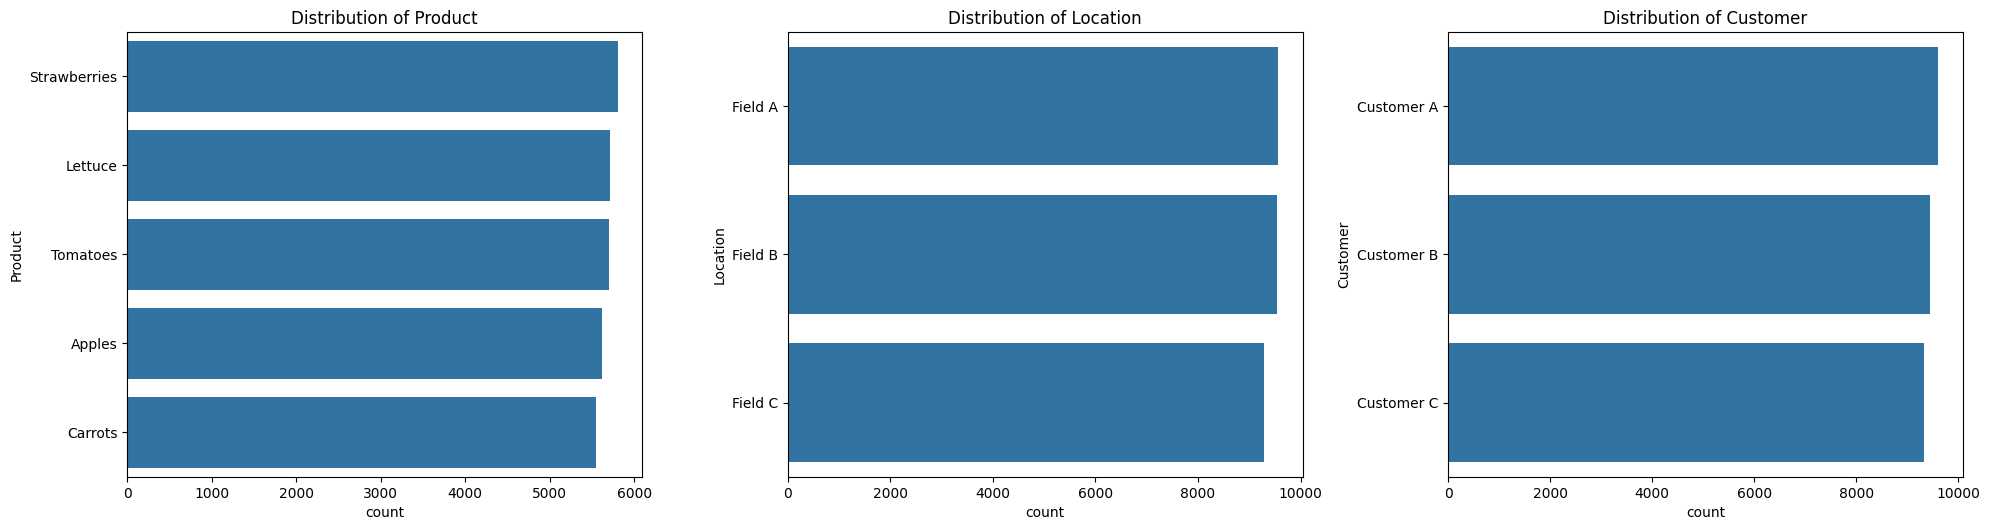

In [11]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 10))

# Plotting bar plots for categorical variables
categorical_vars = ['Product', 'Location', 'Customer']
for i, var in enumerate(categorical_vars, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=df, y=var, order=df[var].value_counts().index)
    plt.title(f'Distribution of {var}')
    plt.tight_layout()

plt.show()

From the plot:
- `Product`: The most frequently sold product is `Strawberries`, while the least frequently sold product is `Carrots`. The others fall inbetween.
- `Location`: The most frequenty sold products come from `Field A` and `Field B`.
- `Customer`: The most frequent buyer is `Customer A`, and `Customer C` is the least frequent buyer.

#### Bivariate Analysis

We will examine the relationship between multiple pair of variables. We will approach this by analysing:
- two numerical variables,
- a numerical and a categorical variables,
- two categorical variables.

##### Bivariate Analysis: Numerical Variables

We will begin by analysing two numerical variables.

The first step will be a correlation matrix plot to see the correlation between two numerical values.

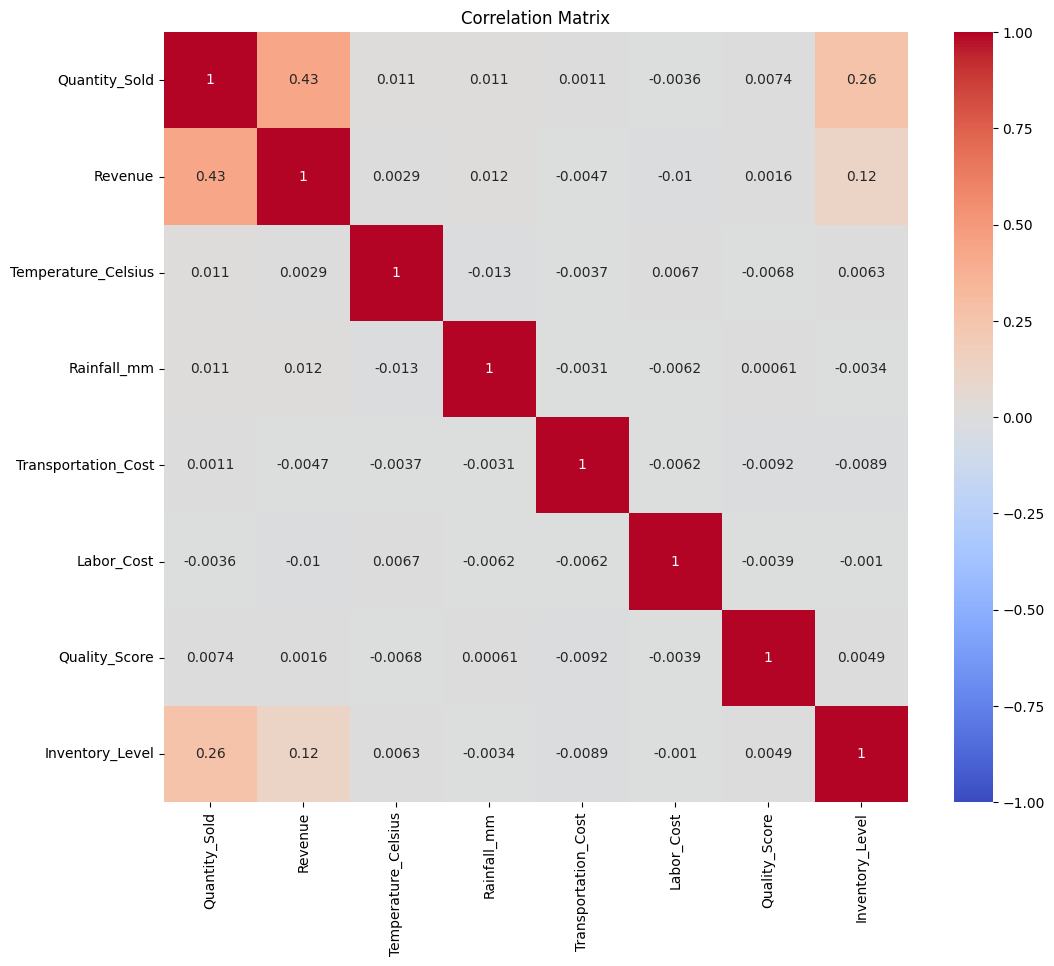

In [12]:
# Compute the correlation matrix
correlation_matrix = df.select_dtypes(include=np.number).corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

A few things to note:
- there is moderate correlation between `Quantity_Sold` and `Revenue`, this indicates that the the higher the quantity of products sold, the higher the revenue, and this is usually the norm for most businesses,
- there is some weak correlation between `Quantity_Sold` and `Inventory_Level`, this may suggest that there seem to be more sales when there is a higher numer of products in inventory,
- there is also some weak correlation between `Revenue` and `Inventory_Level`, this may suggest that the revenue tends to correlate/increase with inventory level,
- although the other correlations are really very weak, the positive correlations between:
    - `Temperature_Celsius` and `Quantity_Sold`,
    - `Rainfall_mm` and `Quantity_Sold`,
    - `Revenue` and `Rainfall_mm`
    
    are still some of the highest (~1%) that exists here.

##### Bivariate Analysis: Numerical and Categorical Variables

Next, we explore the relationship between some of the numerical variables and categorical variables.

We will begin by exploring the `Product` against a number of key variables:
- `Revenue`,
- `Quantity_Sold`, and
- `Quality_Score`.

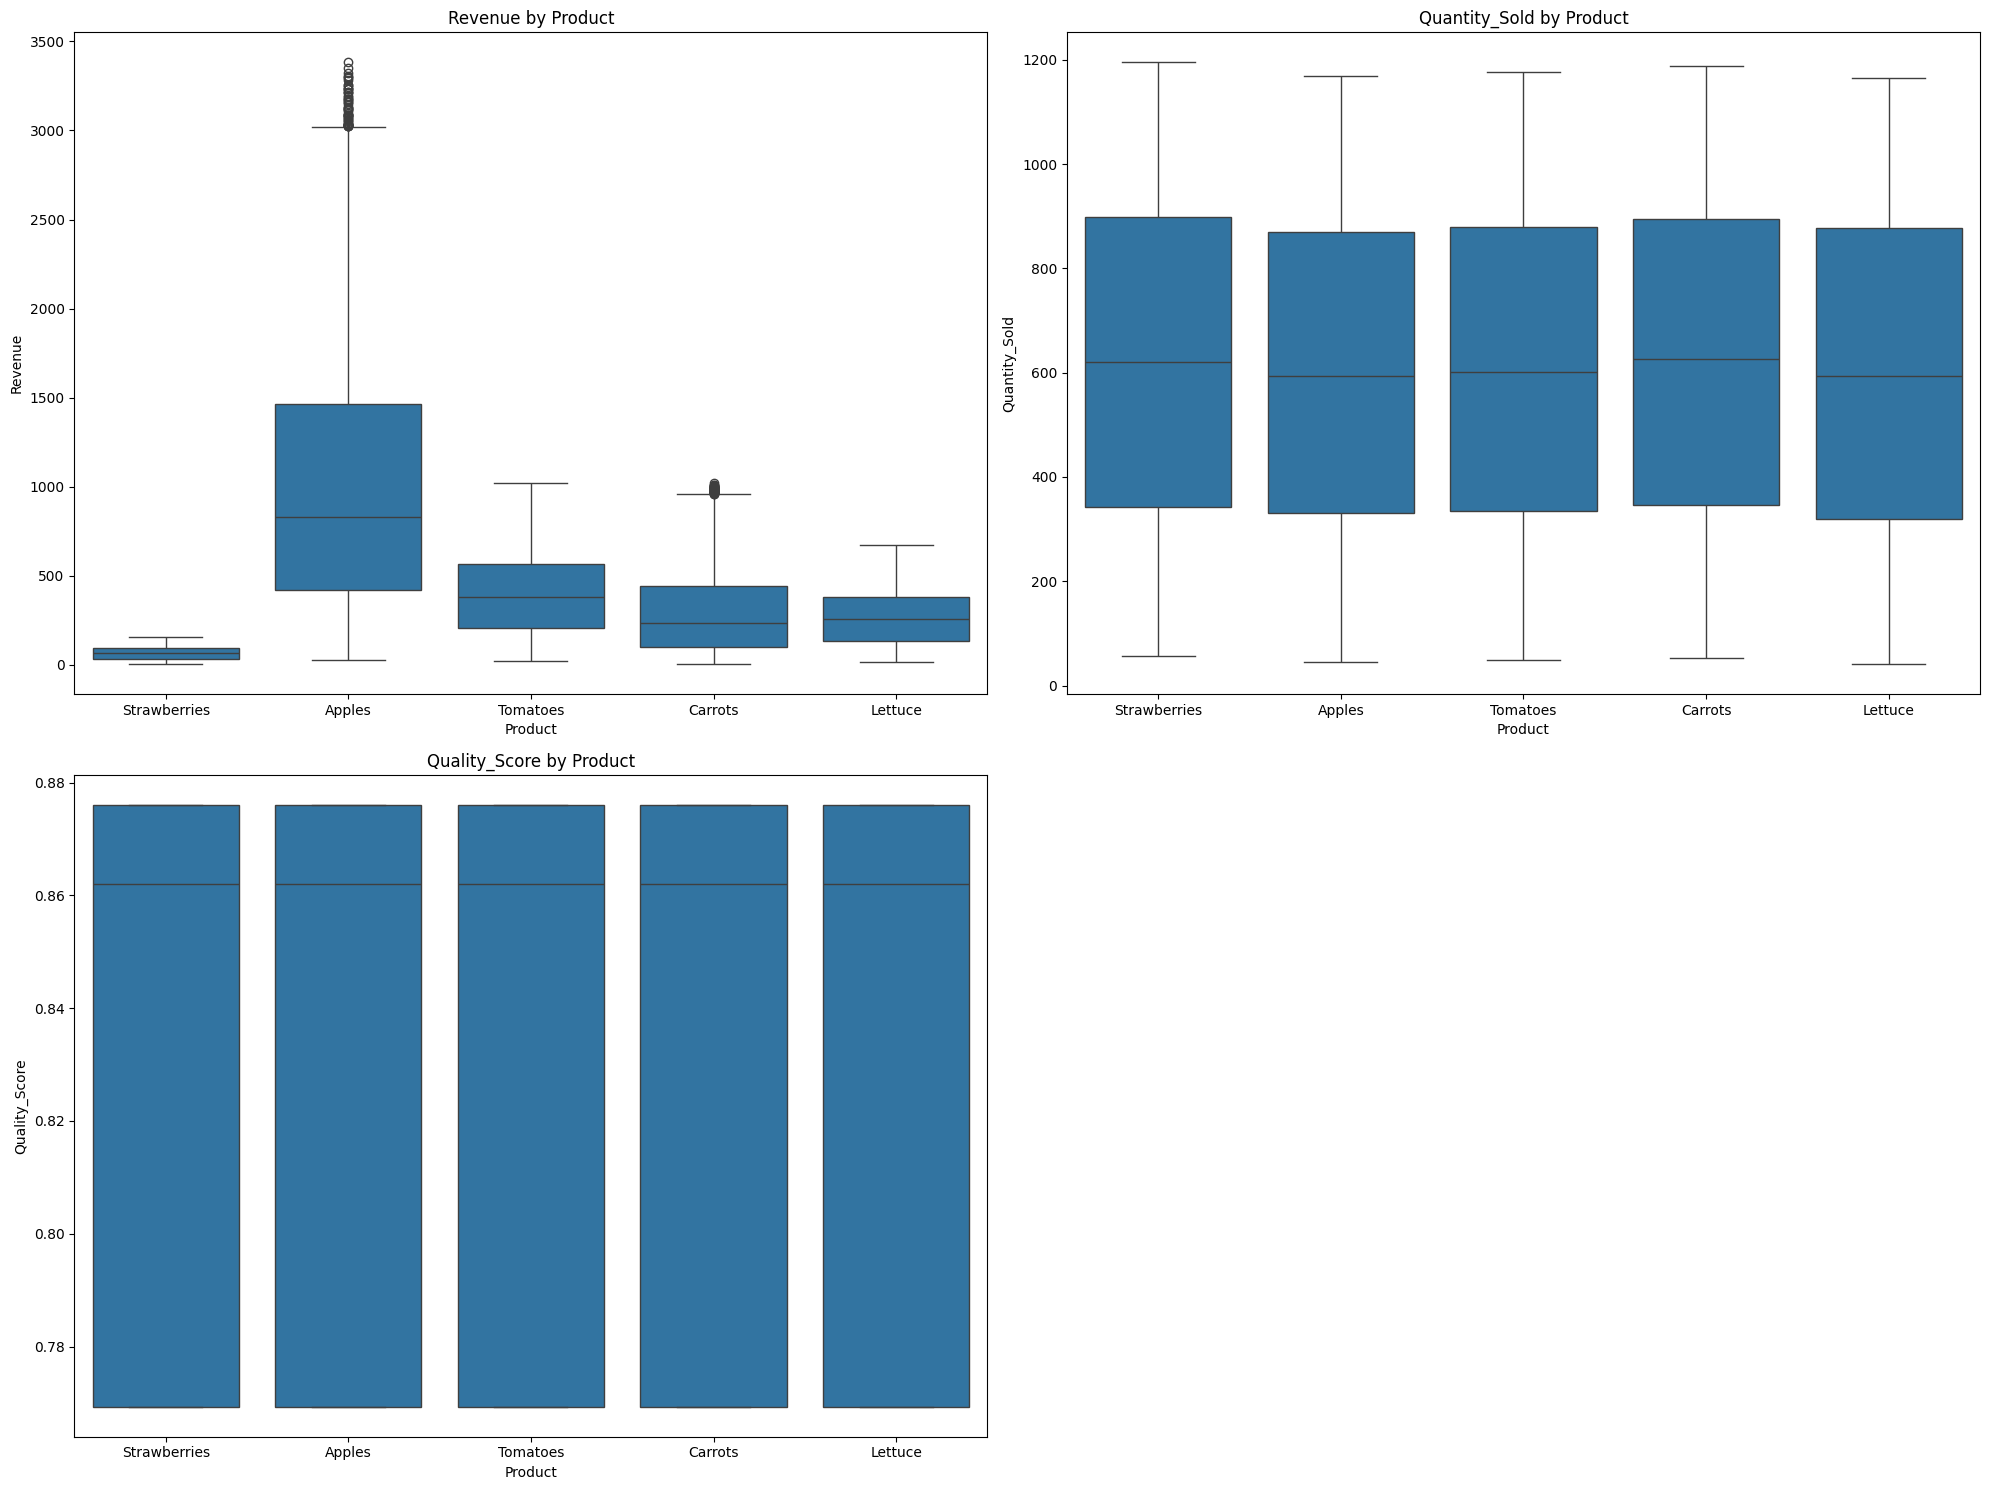

In [13]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

key_numeric_vars = ['Revenue', 'Quantity_Sold', 'Quality_Score']

# Plotting boxplots for the relationship between Product and key numeric variables
for i, var in enumerate(key_numeric_vars, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, x='Product', y=var)
    plt.title(f'{var} by Product')
    plt.tight_layout()

plt.show()

A look at the boxplot:
- `Revenue` by `Product`:
    - Most of the revenue generated from `Tomatoes`, `Carrots` and `Lettuce` per sale tend to fall below $500.
    - Most of the revenue generated from `Strawberries` per sale is usually on the lower side - less than $100.
    - `Apples` have the widest range of revenues for the most part, with most of it's revenue per sale ranges between $400 and $1,500.
- `Quantity_Sold` by `Product`: In most cases, the quantity of products sold per sale fall within 300 and 900.
- `Quality_Score` by `Product`: The distribution of the quality score seems to be very similar across all products.

We will then go to the exploration of the `Location` against the same key variables.

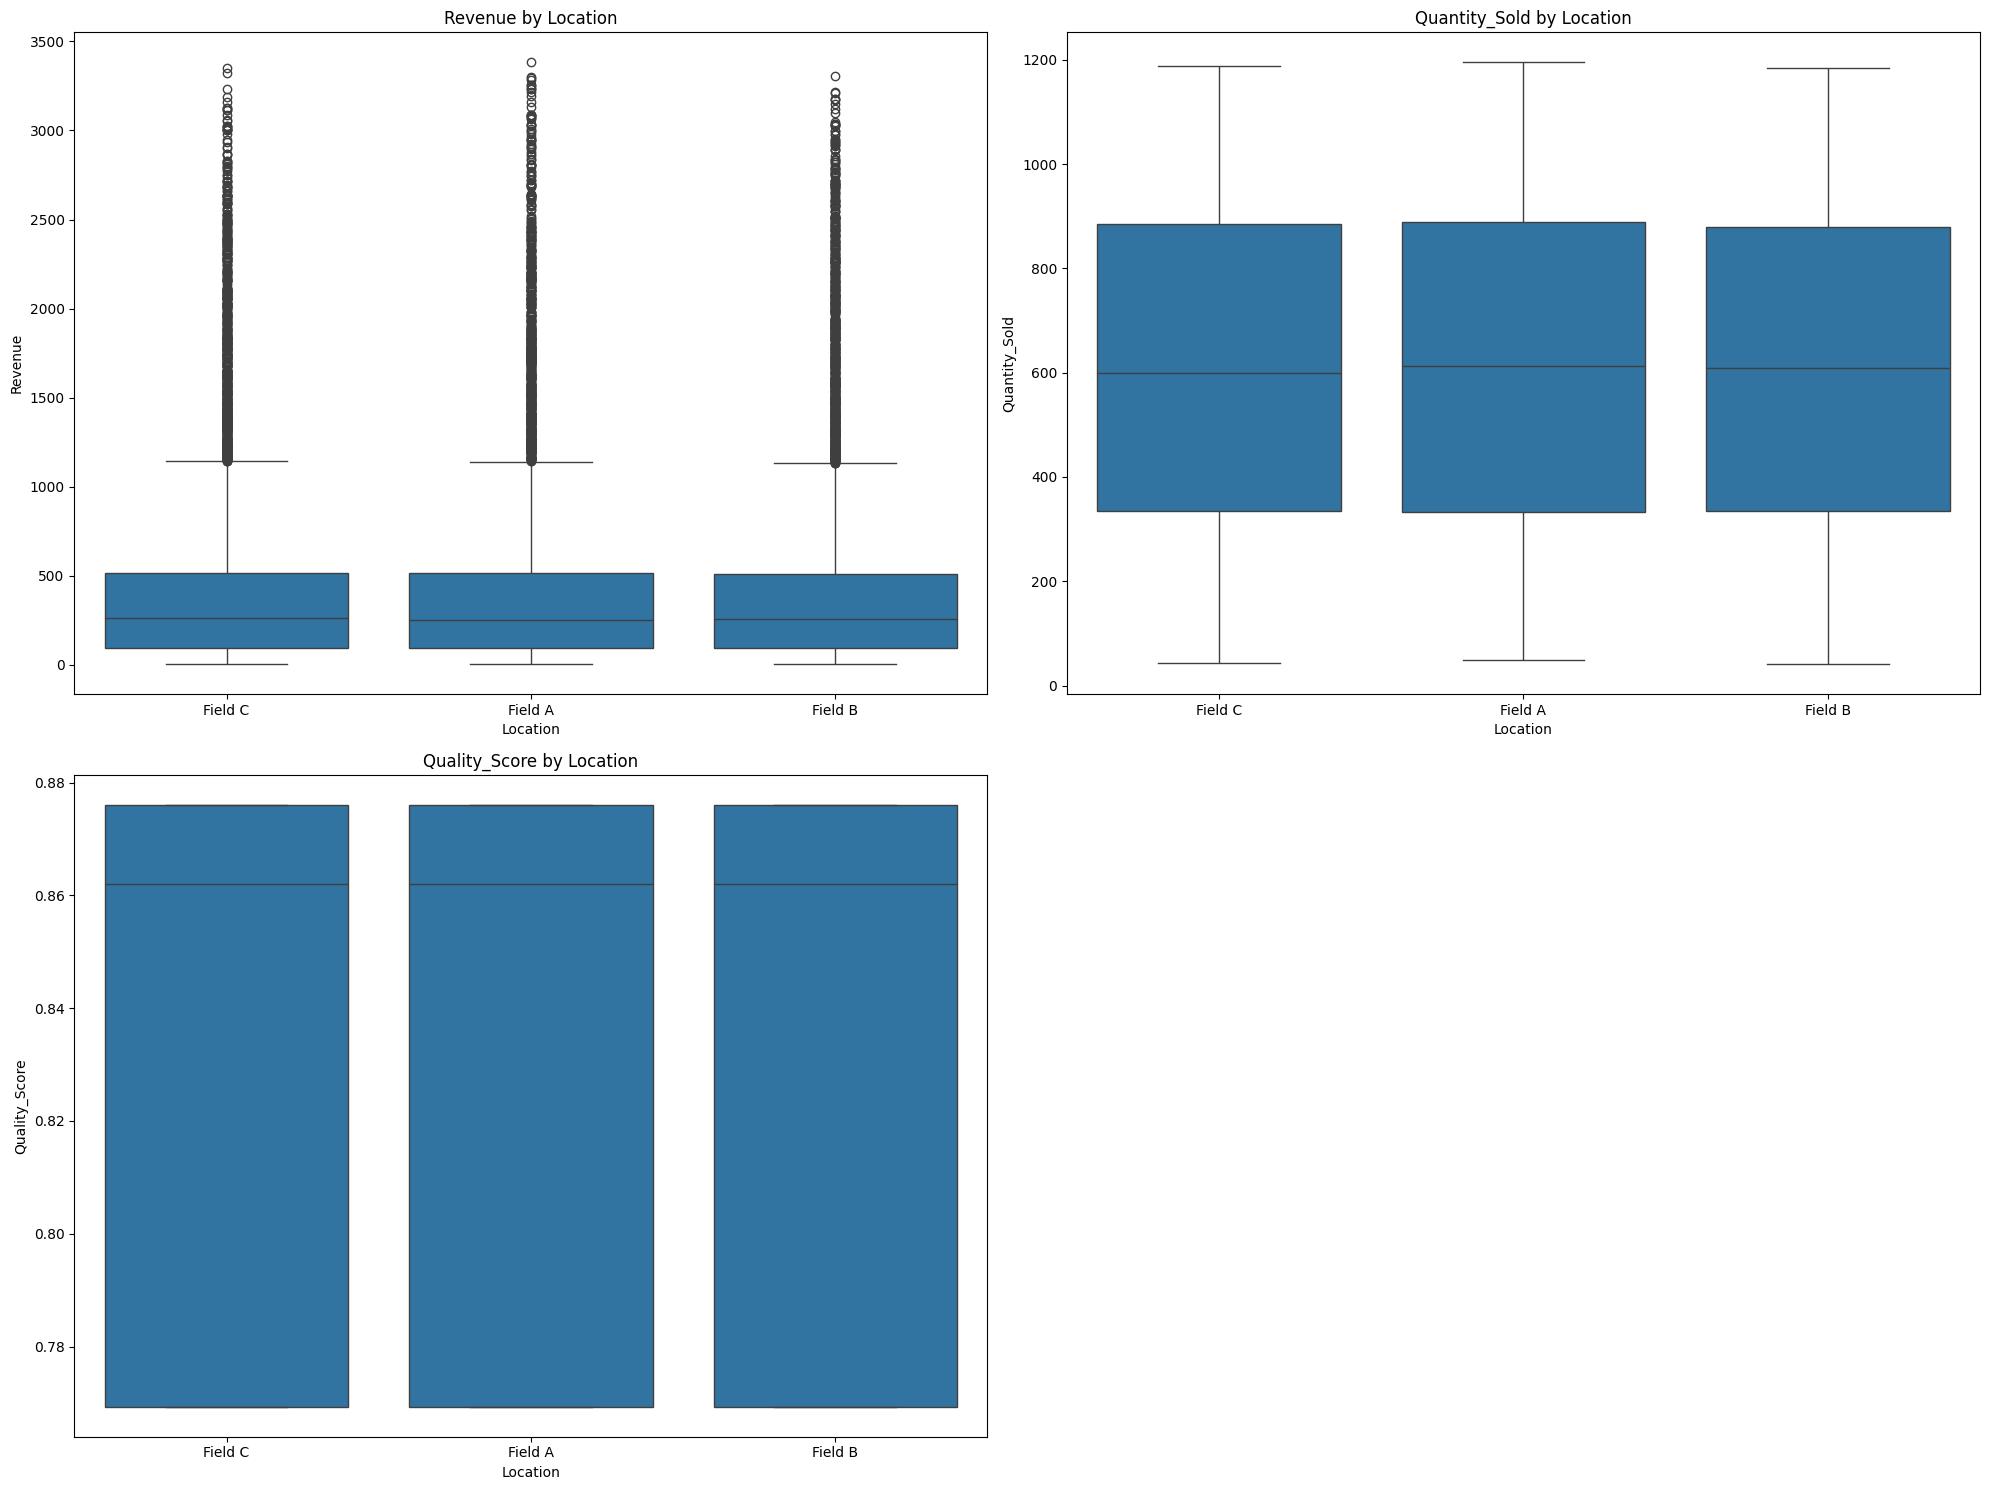

In [14]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# Plotting boxplots for the relationship between Location and same key numeric variables
for i, var in enumerate(key_numeric_vars, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, x='Location', y=var)
    plt.title(f'{var} by Location')
    plt.tight_layout()

plt.show()

From the boxplot:
- `Revenue` by `Location`: There are a lot of outliers above $1000, but most of the values in the interquartile range fall between $0 and $500.
- `Quantity_Sold` by `Location`: This is quantity sold per harvest location is roughly distributed similarly across all the fields. This suggests that the products from each field get an equivalent amount of demands.
- `Quality_Score` by `Location`: The quality score per harvest location is also distributed quick similarly for all fields. This suggests that the quality of products from each field is roughly the same.

Lastly we will then go to the exploration of the `Customer` against the same key variables:
- `Revenue`,
- `Quantity_Sold`, and
- `Quality_Score`.

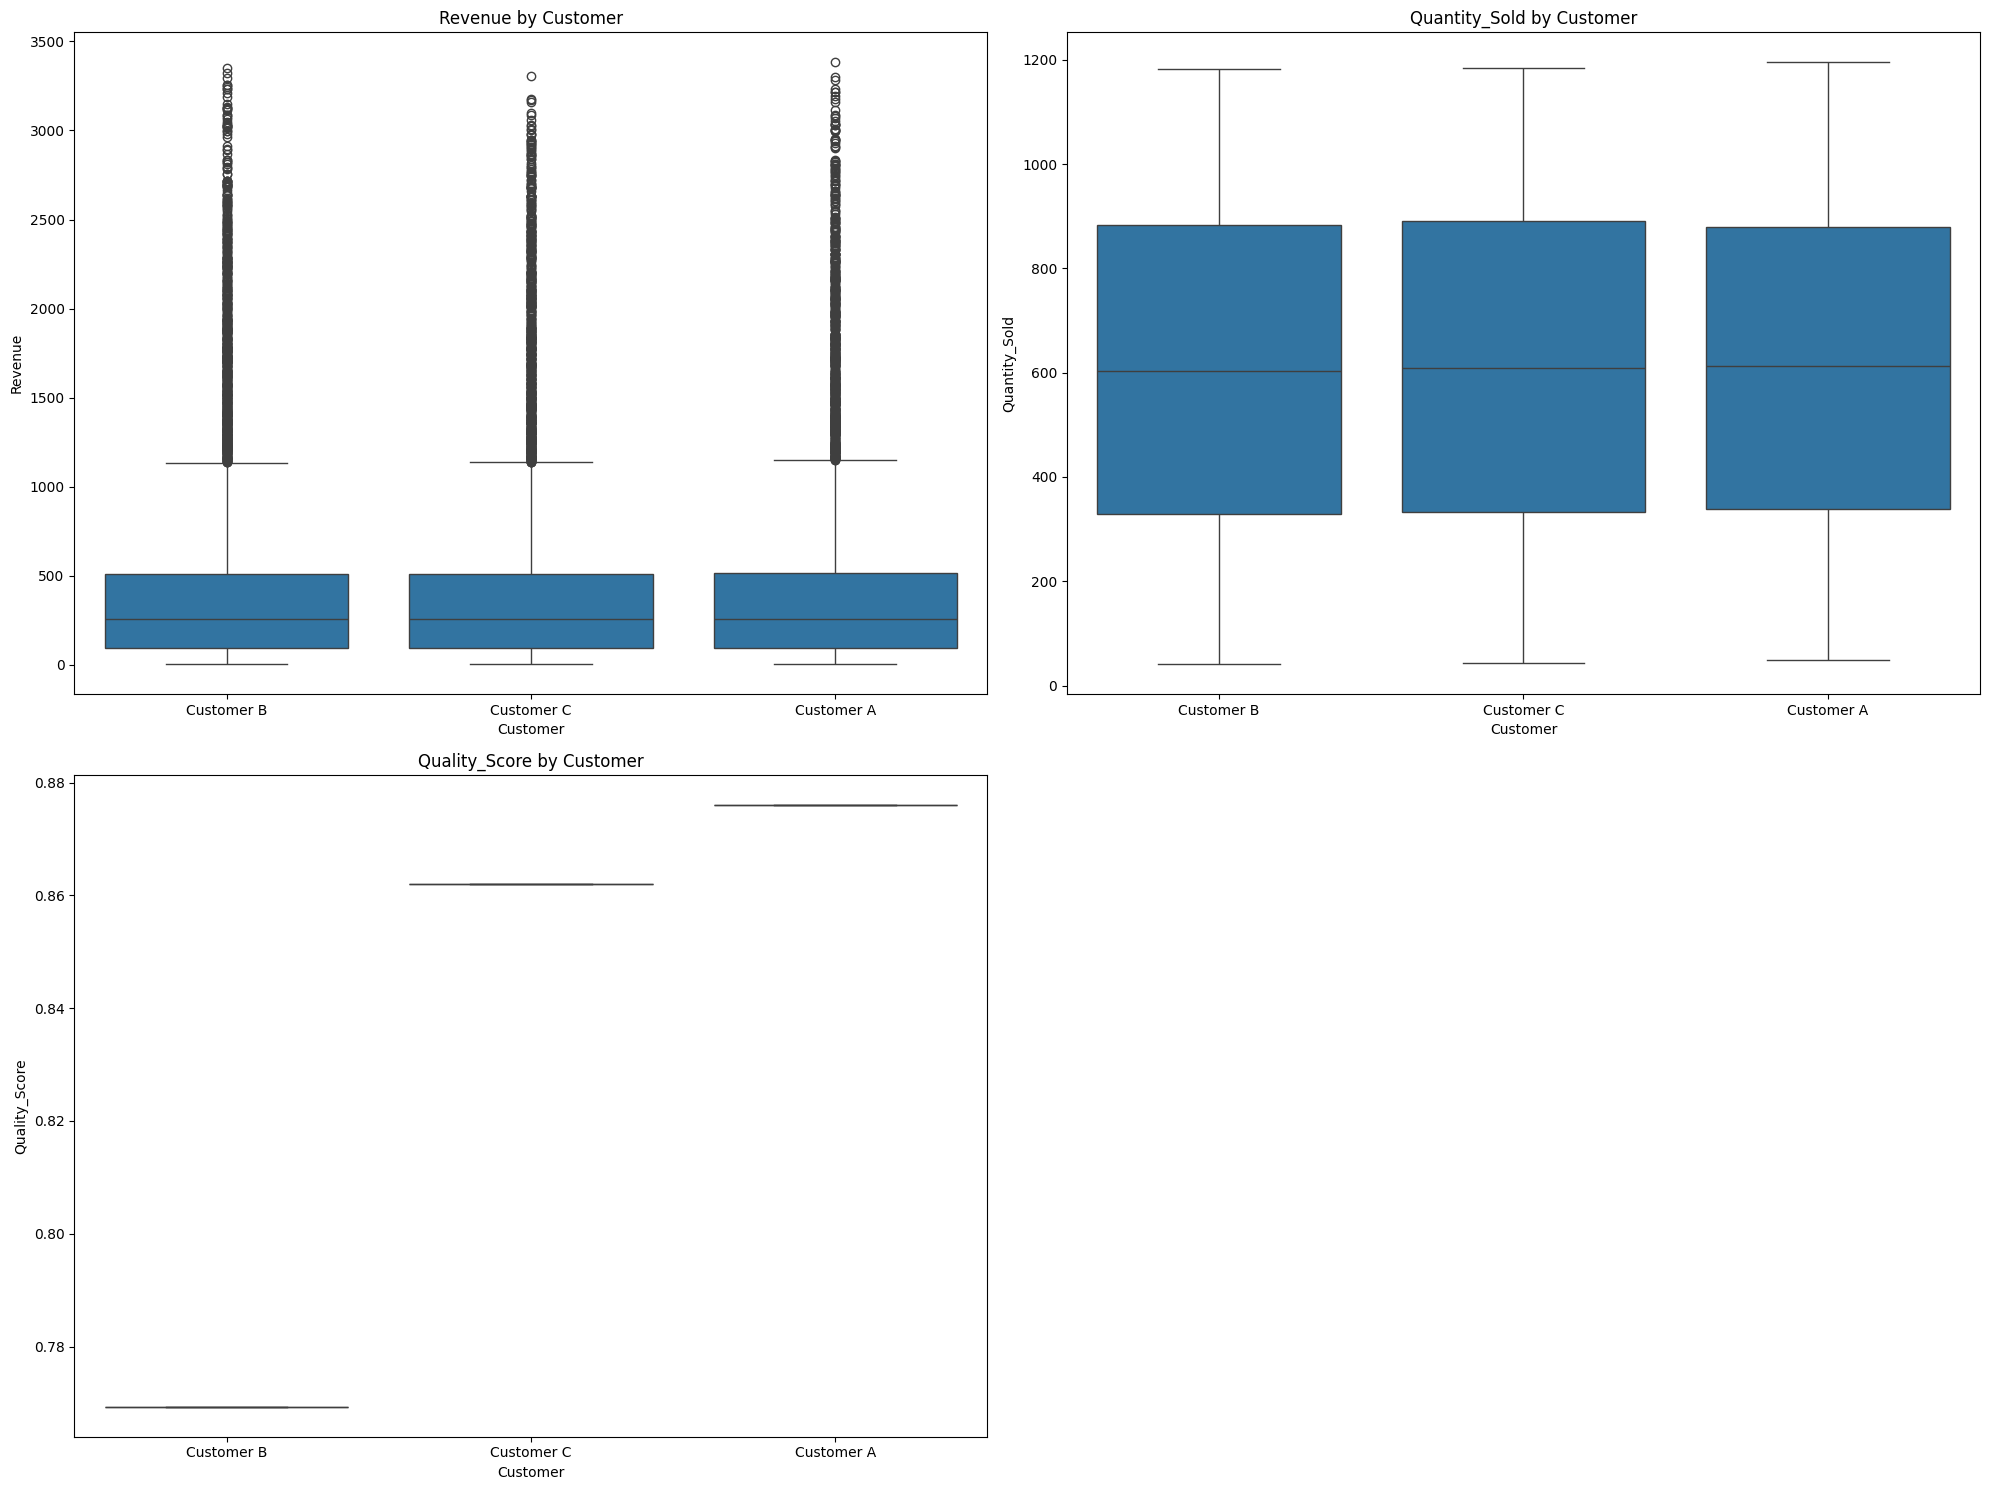

In [15]:
# Key numeric variables
key_numeric_vars = ['Revenue', 'Quantity_Sold', 'Quality_Score']

# Set up the matplotlib figure again
plt.figure(figsize=(20, 15))

# Plotting boxplots for the relationship between Customer and key numeric variables
for i, var in enumerate(key_numeric_vars, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, x='Customer', y=var)
    plt.title(f'{var} by Customer')
    plt.tight_layout()

plt.show()


From the boxplot:
- `Revenue` by `Customer`: The revenue generated per sale per customer is roughly distributed similarly across all customers. This suggests that they all bring in an equivalent amount of revenue to the company.
- `Quantity_Sold` by `Customer`: The quantity of products sold per sale per customer is roughly distributed similarly across all customers. This suggests that they all have an equivalent demand for the company's products.
- `Quality_Score` by `Customer`: `Customer A` buys the most quality products, followed by `Customer C` and `Customer B`.

Next, we're going to be looking at whether or not there are any noticeable differences for:
- `Quantity_Sold` between each products,
- `Revenue` between each products,
- `Quality_Score` between each products.

This should help us see which products has been sold the most.

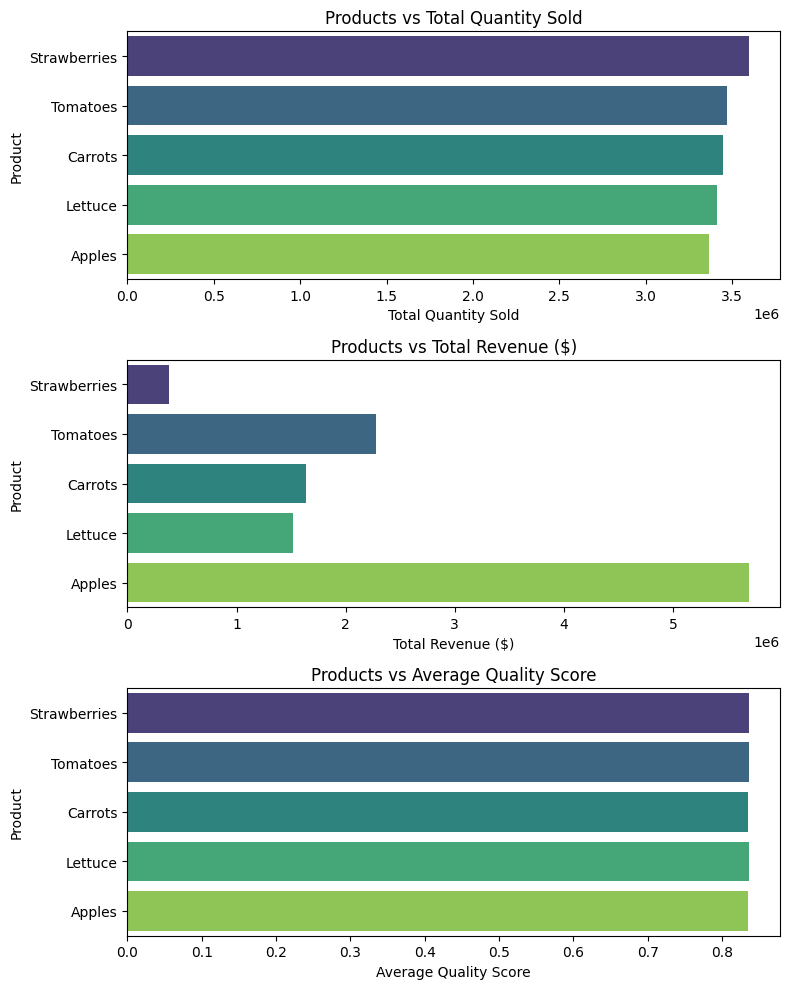

In [16]:
# Group by Product and compute total Quantity_Sold, Revenue, and average Quality_Score
product_data = df.groupby('Product').agg({'Quantity_Sold': 'sum',
                                          'Revenue': 'sum',
                                          'Quality_Score': 'mean'}).reset_index()

# Sorting data for better visualization
product_data = product_data.sort_values(by='Quantity_Sold', ascending=False)

# Plotting
fig, ax = plt.subplots(3, 1, figsize=(8, 10))

# Products vs Total Quantity Sold
sns.barplot(data=product_data, x='Quantity_Sold', y='Product', ax=ax[0], palette='viridis')
ax[0].set_title('Products vs Total Quantity Sold')
ax[0].set_xlabel('Total Quantity Sold')
ax[0].set_ylabel('Product')

# Products vs Total Revenue
sns.barplot(data=product_data, x='Revenue', y='Product', ax=ax[1], palette='viridis')
ax[1].set_title('Products vs Total Revenue ($)')
ax[1].set_xlabel('Total Revenue ($)')
ax[1].set_ylabel('Product')

# Products vs Average Quality Score
sns.barplot(data=product_data, x='Quality_Score', y='Product', ax=ax[2], palette='viridis')
ax[2].set_title('Products vs Average Quality Score')
ax[2].set_xlabel('Average Quality Score')
ax[2].set_ylabel('Product')

plt.tight_layout()
plt.show()


As seen from the plots above:
- In `Product` vs `Quantity_Sold`, we see that `Strawberries` have the highest number of products sold in total at over **3.5 million**, while `Apples` - the lowest has sold about **3.4 million**. The other products fall in between these two values.
- In `Product` vs `Revenue`, we see that `Strawberries` have brought the lowest amount of total revenue to the company at less than **$500,000**, while `Apples` have brought about the highest amount of revenue at about approximately **$6 million**.
- In `Product` vs `Quality_Score`, we see that the average product quality for all categories is approximately the same.

We'll now also take a look at the total quantity of products from each category that each customer has bought over the years. This is aimed at seeing with customers were the heaviest buyers among them.

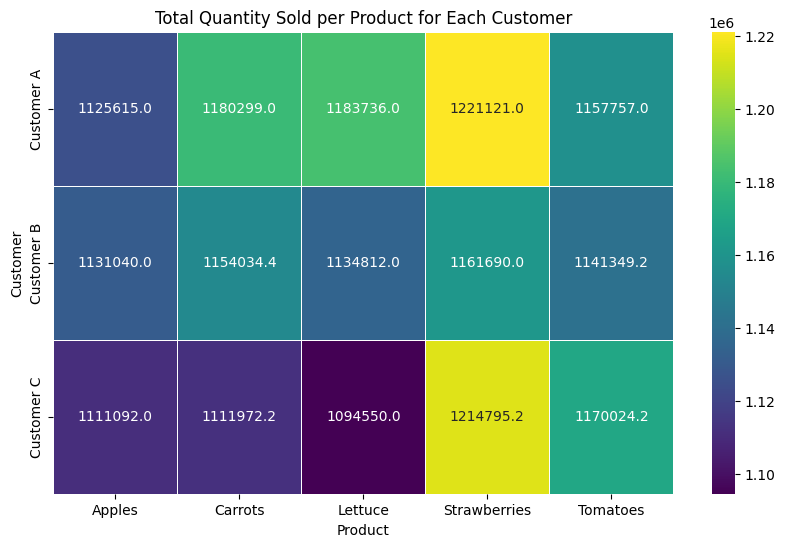

In [17]:
# Group by Customer and compute total Quantity_Sold, Revenue, and average Quality_Score per Product
customer_data = df.groupby(['Customer', 'Product']).agg({'Quantity_Sold': 'sum',
                                                         'Revenue': 'sum',
                                                         'Quality_Score': 'mean'}).reset_index()

# Pivot the data for better visualization
customer_pivot = customer_data.pivot(index='Customer',
                                     columns='Product',
                                     values='Quantity_Sold')

# Plotting
plt.figure(figsize=(10, 6))
sns.heatmap(customer_pivot, annot=True, cmap='viridis', fmt='.1f', linewidths=.5)
plt.title('Total Quantity Sold per Product for Each Customer')
plt.ylabel('Customer')
plt.xlabel('Product')
plt.show()

From the plot, we see that:
- For each product category, each customer has purchased between **1.1 million** to **1.22 million** quantity each,
- For all of the products, `Strawberries` have the highest demand, as seen from the yellow color on the it's plot,
- From the color on the plot for `Customer A`, it is evident that `Customer A` is the heaviest buyer of products.

##### Bivariate Analysis: Two Categorical Variables

Here, we explore the relationship between pairs of categorical variables.

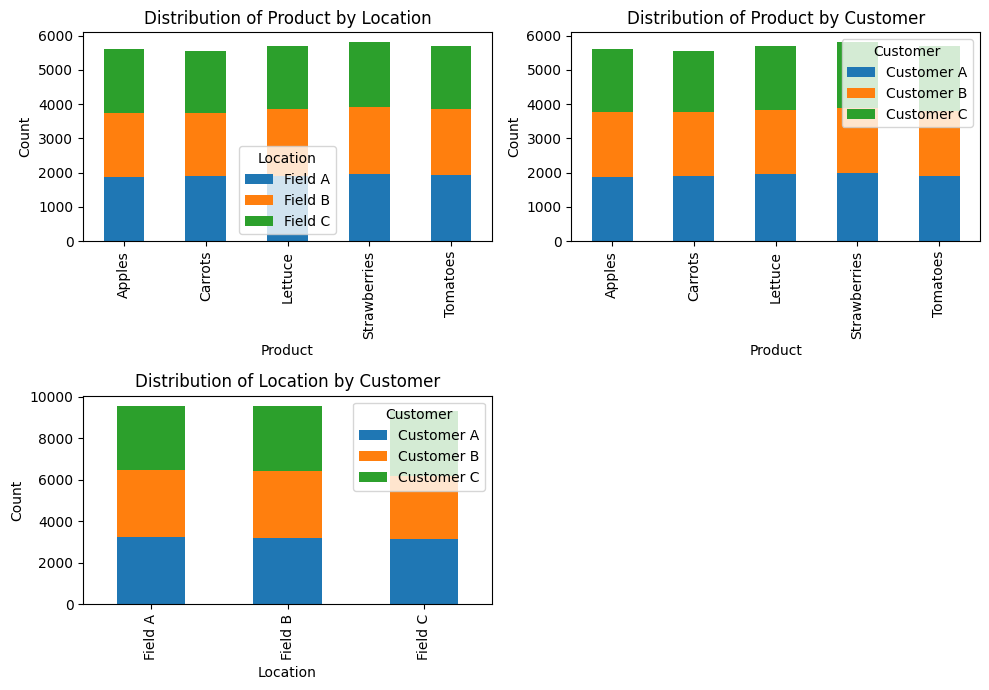

In [18]:
plt.figure(figsize=(10, 15))

pairs = [('Product', 'Location'),
         ('Product', 'Customer'),
         ('Location', 'Customer')]

for i, (p1, p2) in enumerate(pairs):
    # Explore the relationship between two categorical variables
    contingency_table = pd.crosstab(df[p1], df[p2])

    # Plotting the stacked bar chart for two categorical variables
    ax = plt.subplot(2, 2, i+1)
    contingency_table.plot(kind='bar', stacked=True, figsize=(10, 7), ax=ax)
    plt.title(f'Distribution of {p1} by {p2}')
    plt.ylabel('Count')
    plt.xlabel(p1)

plt.tight_layout()

plt.show()

From the plot, the distributions among pairs of categorical variables are roughly the same.

#### Multivariate Analysis

We will be performing multivariate analysis here, were w will analyze the relationship between multiple variables, use heatmaps and pair plots for visualizations, and plot 3D plots for visualization.

We begin by plotting pair plots for the key numeric variables colored by Product.

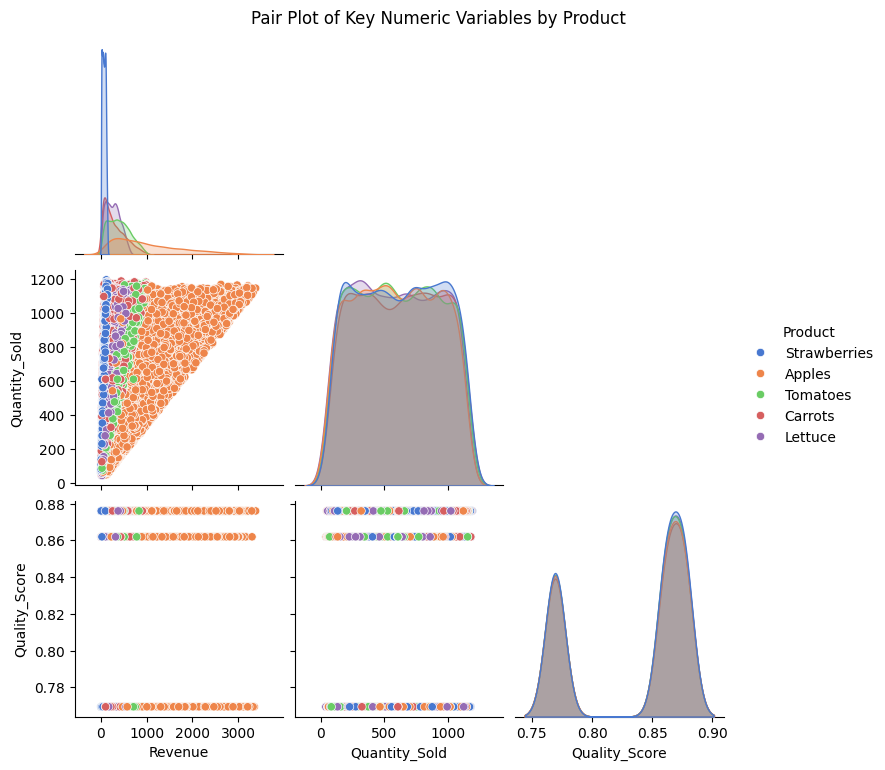

In [19]:
pair_plot = sns.pairplot(df, hue='Product', vars=key_numeric_vars, palette='muted', corner=True)
pair_plot.fig.suptitle('Pair Plot of Key Numeric Variables by Product', y=1.02)

plt.show()

From the pair plot:
- `Quantity_Sold` vs `Revenue`: `Apples` have the widest distribution of revenue ($0 to $3,000), while the revenue from `Strawberries` are usually the lowest.
- `Quality_Score` vs `Revenue`: `Strawberries` are usually the highest quality products (0.86 to 0.88 quality scores). `Apples` have the widest range of revenues, while the others bring in revenue at different quality scores/levels.
- `Quality_Score` vs `Quantity_Sold`: From the plot, the quality score is clustered around 0.78, 0.86-0.88. There is a seemingly wide distribution between quality and quantity for each product.

#### Temporal Analysis

Here, we will look at some time based trends. Here, we will try to answer the question of how the Quantity of products sold, and Revenue generated changes over time. We will be plotting a daily trend to see if there are patterns or seasonalities.

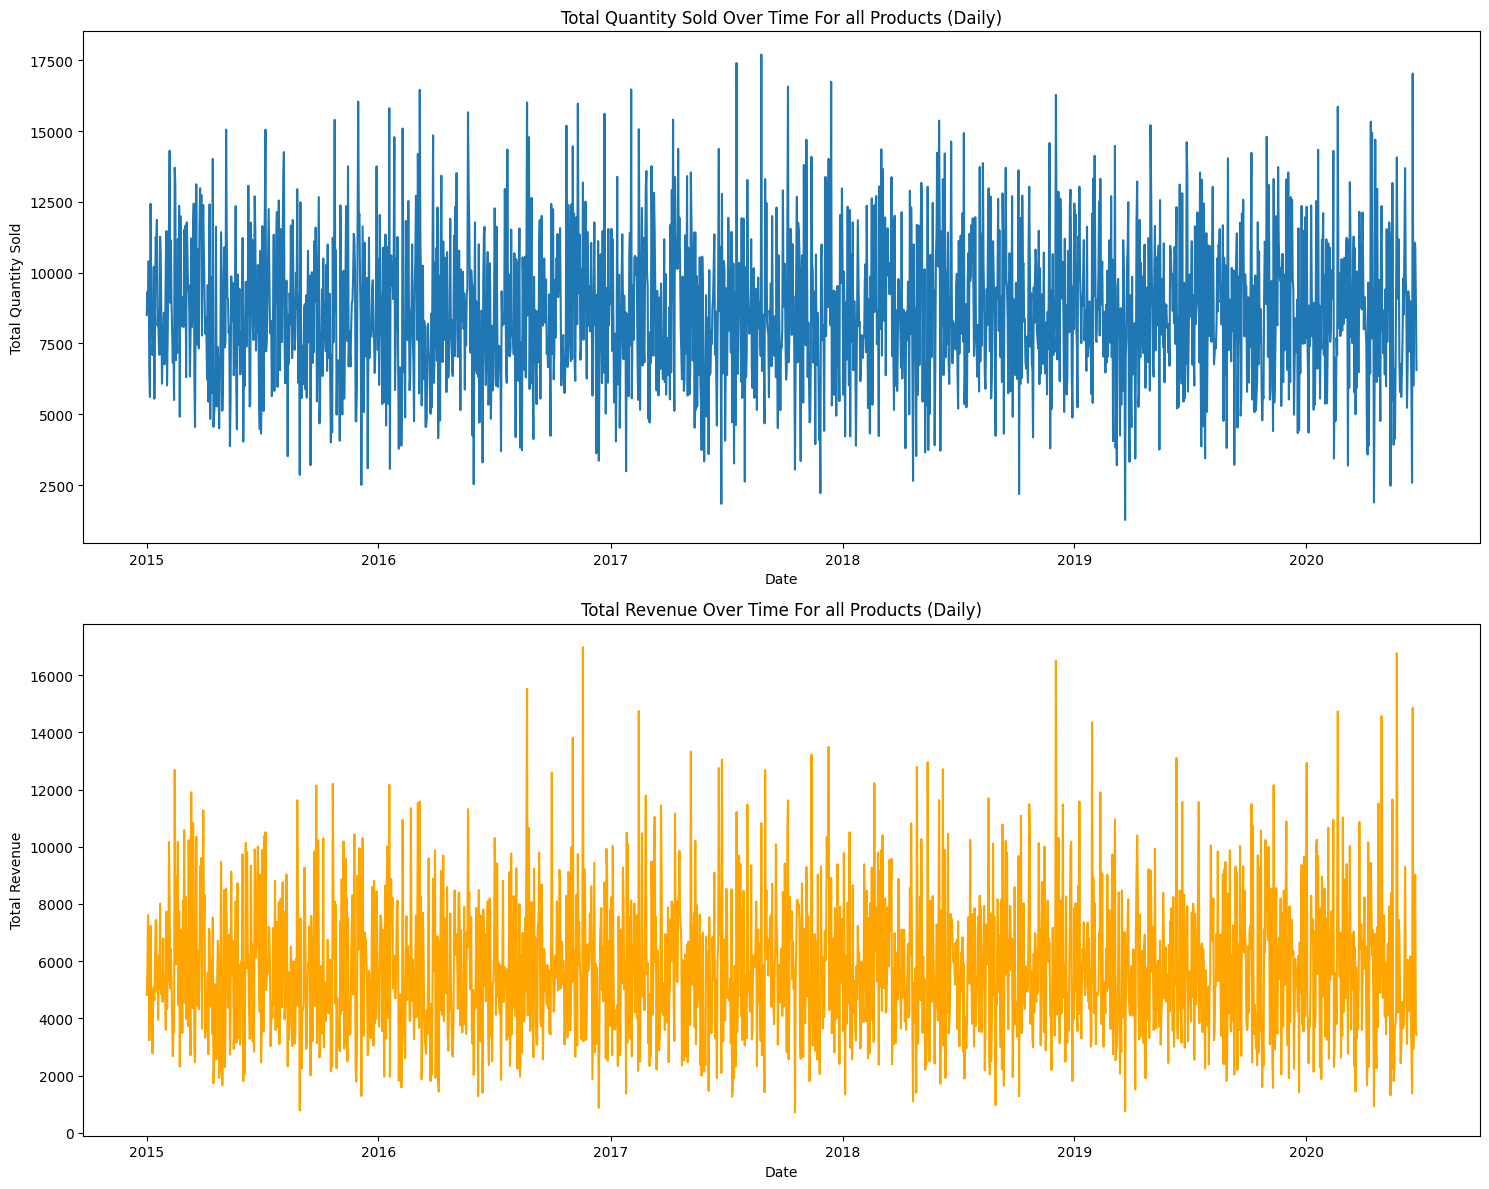

In [21]:
# Convert the Date column to a datetime object for groupings
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y') # Specify the correct date format

# Group by Date and sum up Quantity_Sold and Revenue
time_based_data = df.groupby('Date').agg({'Quantity_Sold': 'sum', 'Revenue': 'sum'}).reset_index()

# Plotting Quantity_Sold and Revenue over time
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# Quantity Sold over Time
sns.lineplot(data=time_based_data, x='Date', y='Quantity_Sold', ax=ax[0])
ax[0].set_title('Total Quantity Sold Over Time For all Products (Daily)')
ax[0].set_ylabel('Total Quantity Sold')

# Revenue over Time
sns.lineplot(data=time_based_data, x='Date', y='Revenue', ax=ax[1], color='orange')
ax[1].set_title('Total Revenue Over Time For all Products (Daily)')
ax[1].set_ylabel('Total Revenue')

plt.tight_layout()
plt.show()

From the plot for Quantity Sold, there seems to be some wavy-like patterns in the dataset, we'll have to make other plots to confirm if what we're seeing is true or not.

Let's make the same plot, but aggregated weekly in order to see if we can get a clearer picture of what is going on - if any.

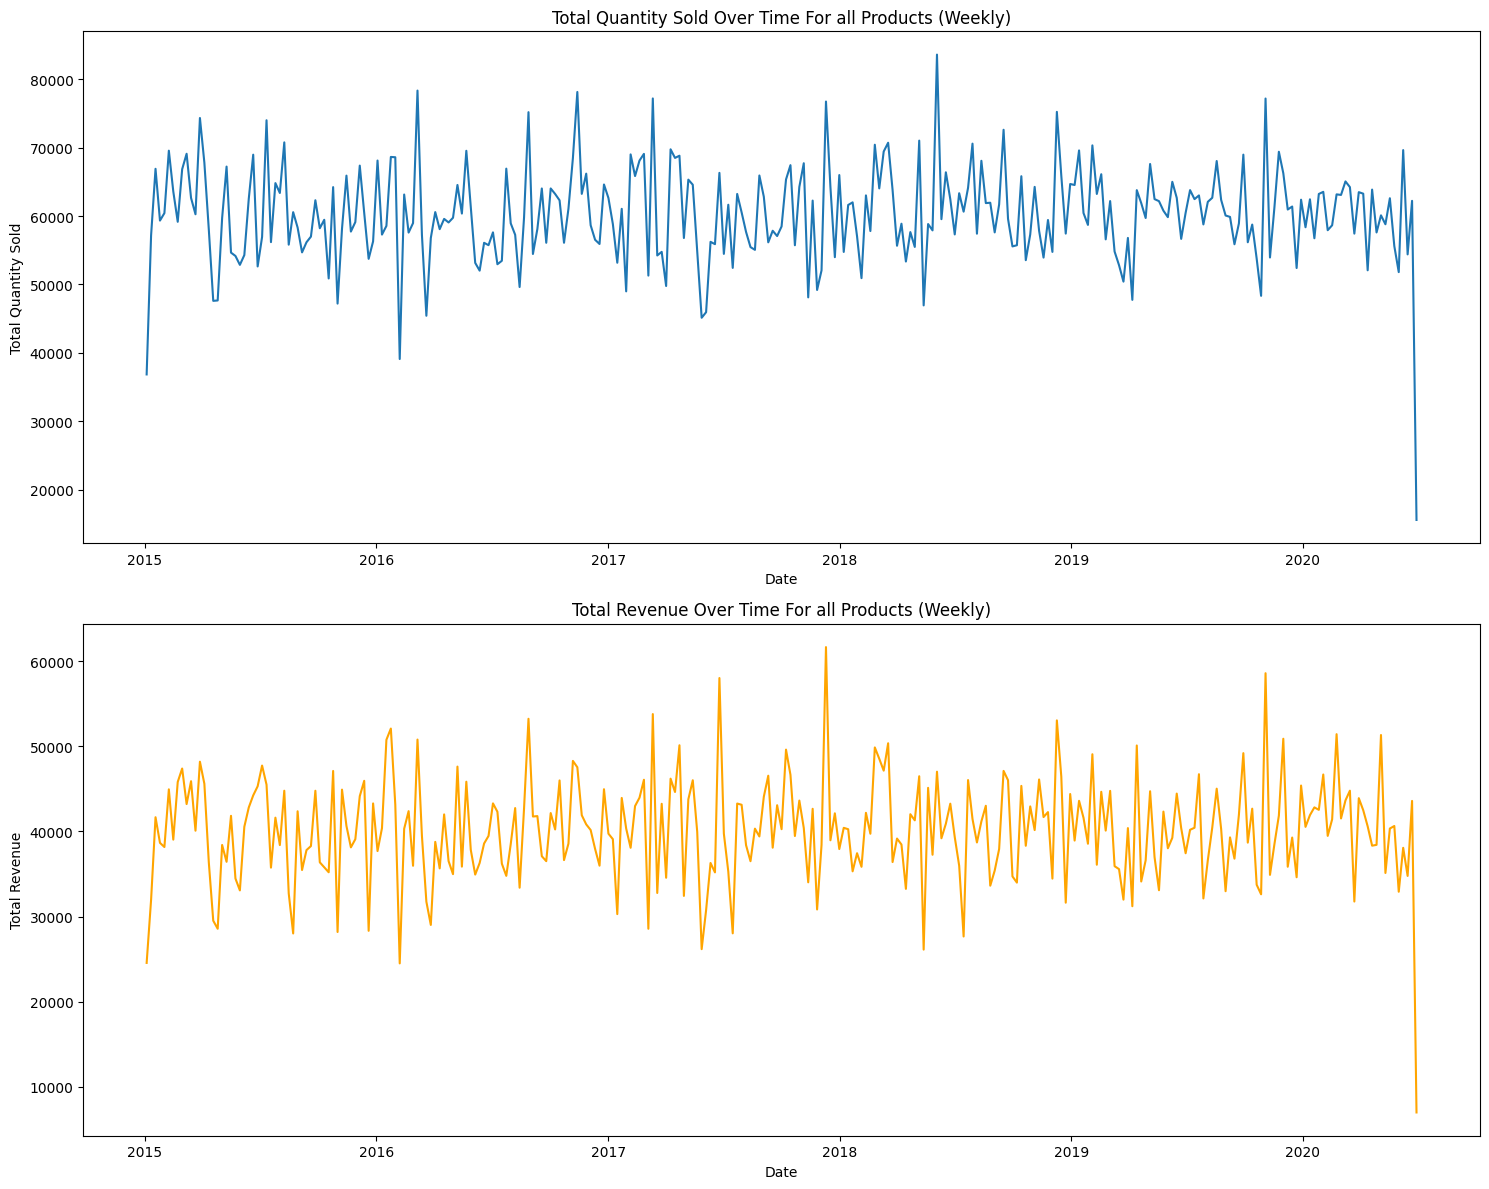

In [22]:
# Group by Date and sum up Quantity_Sold and Revenue
time_based_data = df.groupby('Date').agg({'Quantity_Sold': 'sum', 'Revenue': 'sum'}).reset_index()

# Resample the data to a weekly frequency
time_based_data = time_based_data.set_index('Date').resample('W').sum().reset_index()

# Plotting Quantity_Sold and Revenue over time
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# Quantity Sold over Time
sns.lineplot(data=time_based_data, x='Date', y='Quantity_Sold', ax=ax[0])
ax[0].set_title('Total Quantity Sold Over Time For all Products (Weekly)')
ax[0].set_ylabel('Total Quantity Sold')

# Revenue over Time
sns.lineplot(data=time_based_data, x='Date', y='Revenue', ax=ax[1], color='orange')
ax[1].set_title('Total Revenue Over Time For all Products (Weekly)')
ax[1].set_ylabel('Total Revenue')

plt.tight_layout()
plt.show()

Lastly, we will repeat the same for the data on a monthly basis. The aim is still to see if we can get some patterns from the plot.

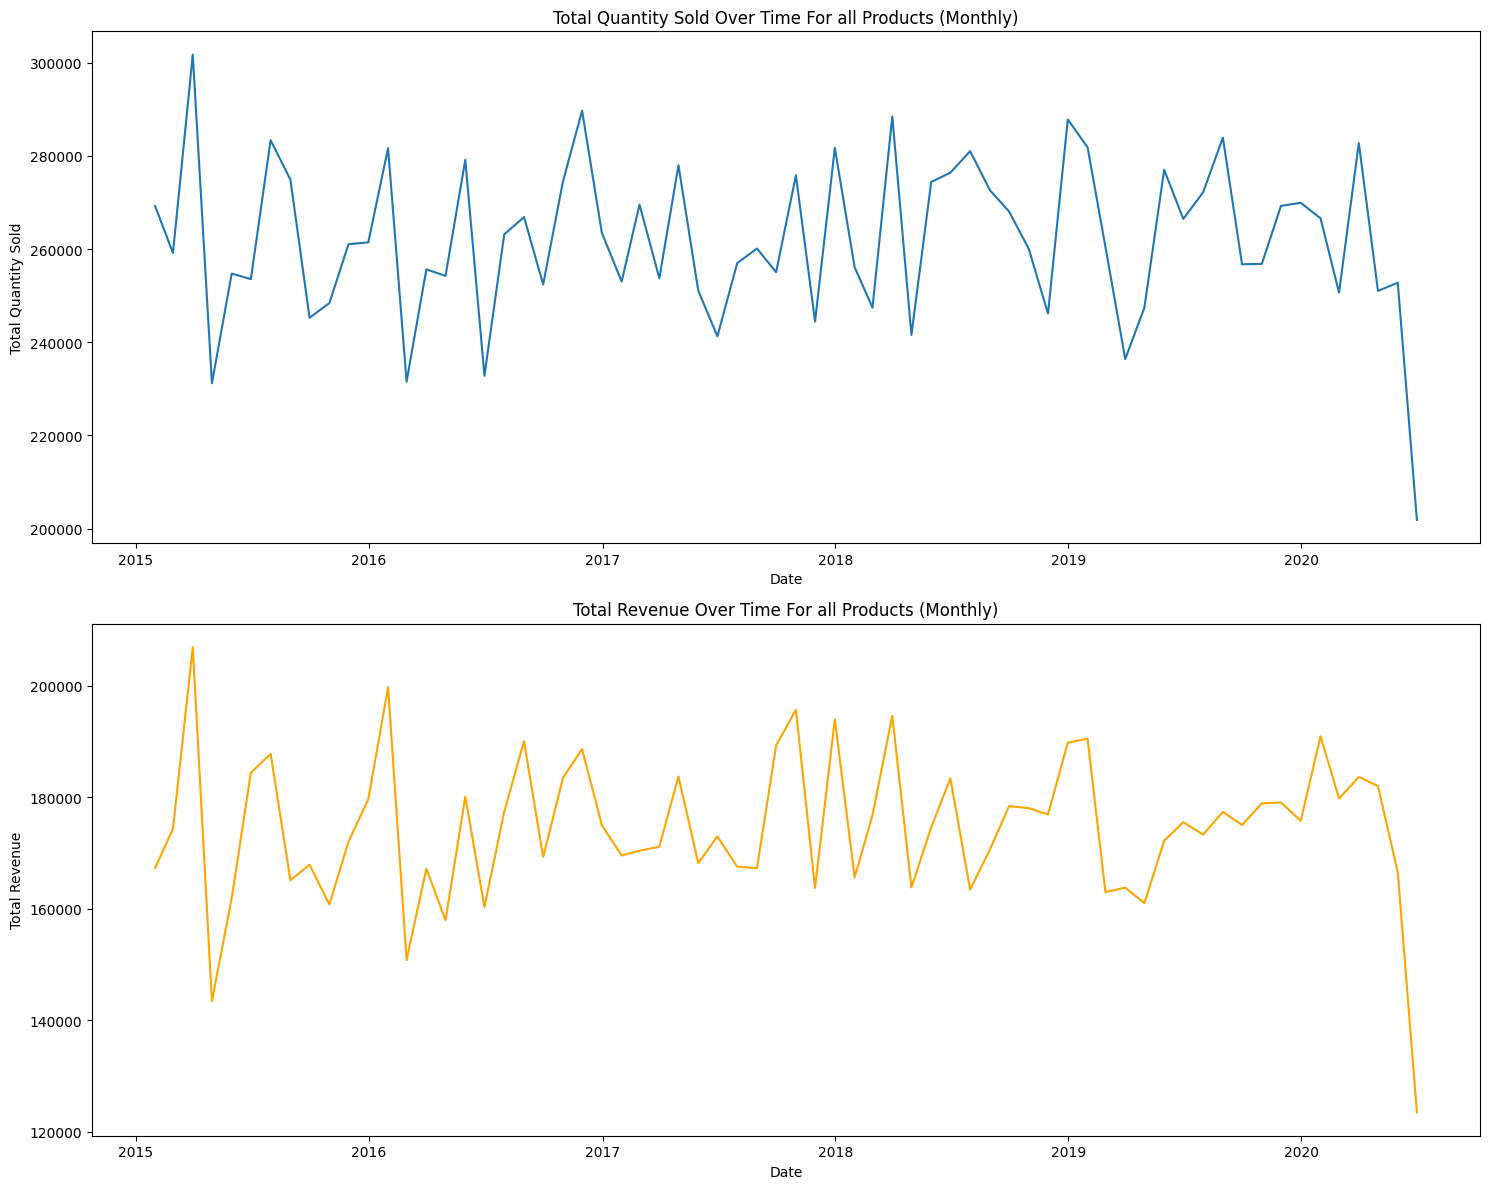

In [23]:
# Group by Date and sum up Quantity_Sold and Revenue
time_based_data = df.groupby('Date').agg({'Quantity_Sold': 'sum', 'Revenue': 'sum'}).reset_index()

# Resample the data to a monthly frequency
time_based_data = time_based_data.set_index('Date').resample('M').sum().reset_index()

# Plotting Quantity_Sold and Revenue over time
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# Quantity Sold over Time
sns.lineplot(data=time_based_data, x='Date', y='Quantity_Sold', ax=ax[0])
ax[0].set_title('Total Quantity Sold Over Time For all Products (Monthly)')
ax[0].set_ylabel('Total Quantity Sold')

# Revenue over Time
sns.lineplot(data=time_based_data, x='Date', y='Revenue', ax=ax[1], color='orange')
ax[1].set_title('Total Revenue Over Time For all Products (Monthly)')
ax[1].set_ylabel('Total Revenue')

plt.tight_layout()
plt.show()

From the above plot, there doesn't seem to be any recurring patterns that can be easily identified.

Lastly, we will repeat the same monthly plot, but we will be doing it for different product categories separately, the aim for this is to look for recurring patterns in each of the plots separately.

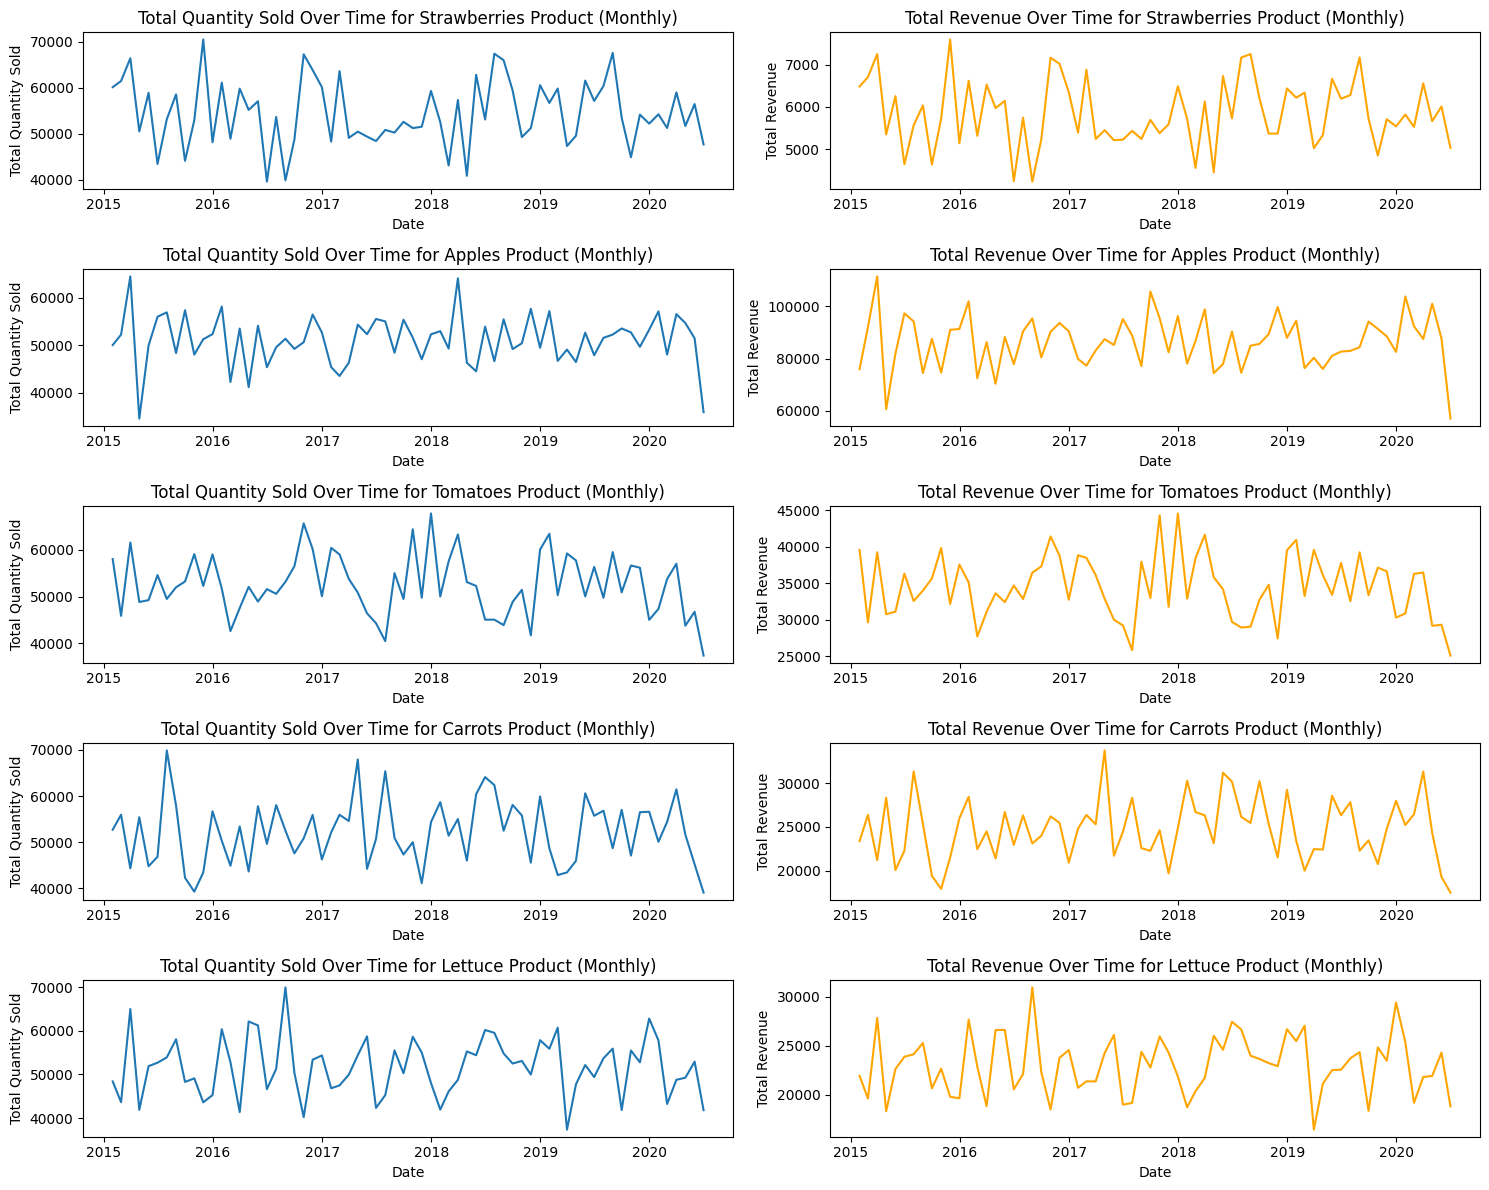

In [ ]:
# Get all product names
products = df['Product'].unique()

# Plotting Quantity_Sold and Revenue over time
fig, ax = plt.subplots(len(products), 2, figsize=(15, 12))

for i in range(len(products)):
    product = products[i]

    # Get the subset of the products
    time_based_data = df[df['Product'] == product]

    # Group by Date and sum up Quantity_Sold and Revenue
    time_based_data = time_based_data.groupby('Date').agg({'Quantity_Sold': 'sum',
                                                           'Revenue': 'sum'}).reset_index()

    # Resample the data to a monthly frequency
    time_based_data = time_based_data.set_index('Date').resample('M').sum().reset_index()

    # Quantity Sold over Time
    sns.lineplot(data=time_based_data, x='Date', y='Quantity_Sold', ax=ax[i, 0])
    ax[i, 0].set_title(f'Total Quantity Sold Over Time for {product} Product (Monthly)')
    ax[i, 0].set_ylabel('Total Quantity Sold')

    # Revenue over Time
    sns.lineplot(data=time_based_data, x='Date', y='Revenue', ax=ax[i, 1], color='orange')
    ax[i, 1].set_title(f'Total Revenue Over Time for {product} Product (Monthly)')
    ax[i, 1].set_ylabel('Total Revenue')

plt.tight_layout()
plt.show()

There are still no visible or easily identifiable patterns.

### Feature Engineering

In the Feature Engineering section, we will simply be splitting our data into train and test sets for each of the product categories. All data from collected below 2019 will be used for training, and all data collected from 2019 will be used for testing. The data being stored will first be aggregated into **months** first before they are stored.

In [ ]:
# Create dictionaries to store the weekly train and test data for each product
# category
train_data = dict()
test_data = dict()

for product in products:

    # Separate the other products from the dataset
    df_product = df[df['Product'] == product]

    # Group by Date and sum up Quantity_Sold and Revenue
    df_product = df_product.groupby('Date').agg({'Quantity_Sold': 'sum',
                                                 'Revenue': 'sum'}).reset_index()

    # Resample the data to a monthly frequency
    df_product = df_product.set_index('Date').resample('M').sum().reset_index()

    # Get and store the train and test sets for the product
    train_data[product] = df_product[df_product['Date'].dt.year < 2019].reset_index()
    test_data[product] = df_product[df_product['Date'].dt.year >= 2019].reset_index()

Now, let's visualize this data split.

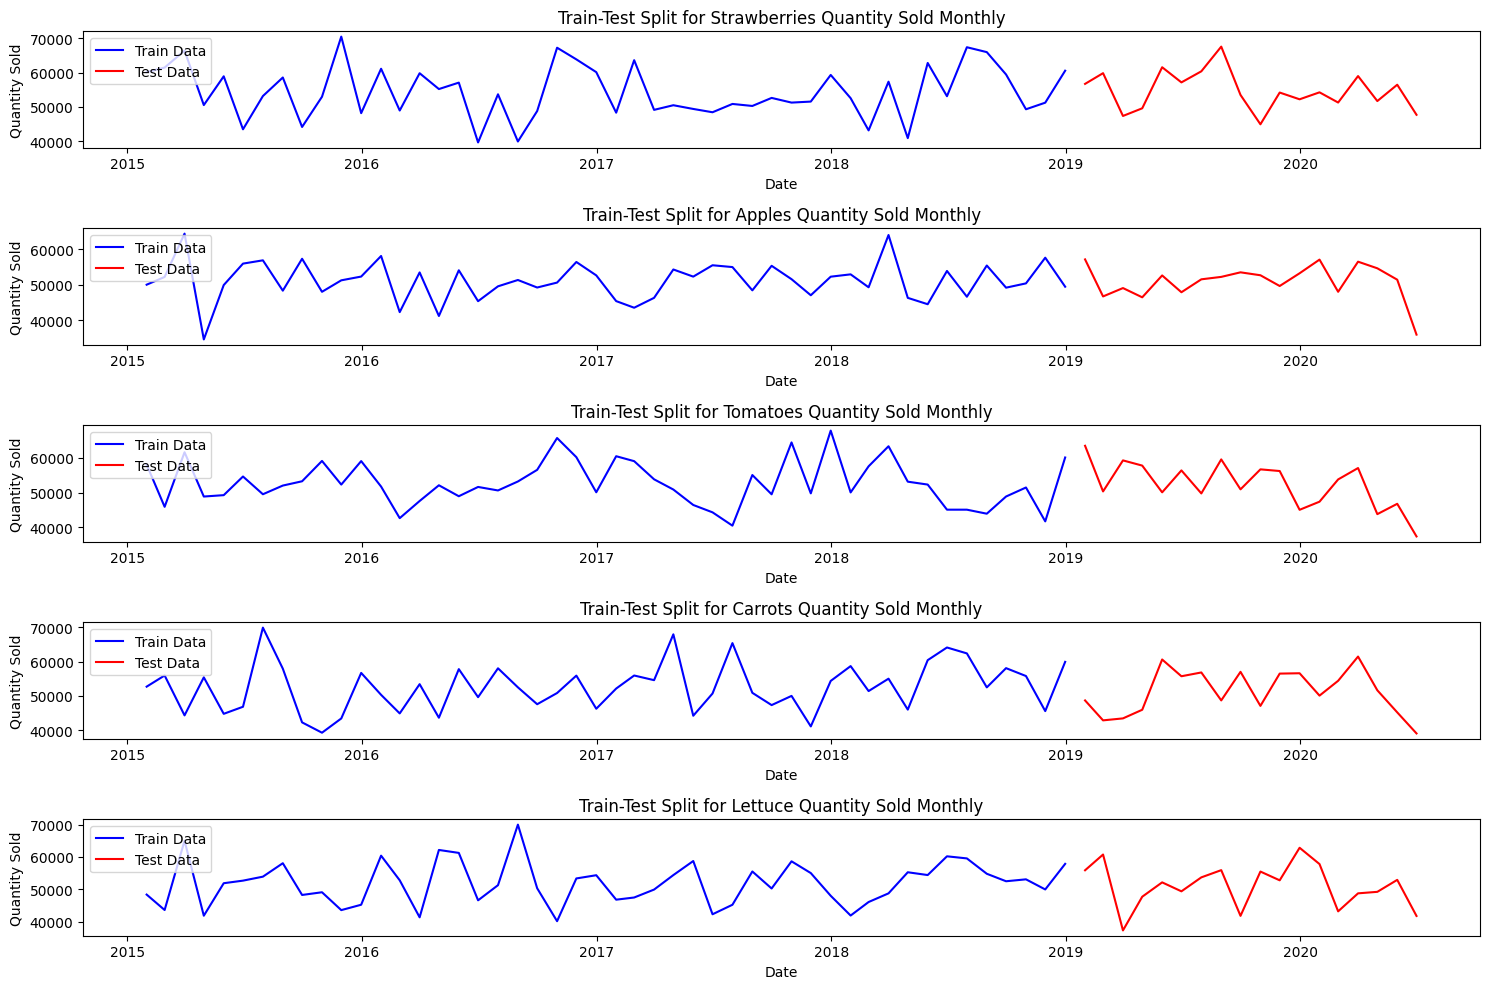

In [ ]:
fig, ax = plt.subplots(len(products), 1, figsize=(15, 10))

for i in range(len(products)):

    # Get the product name
    product = products[i]

    # Plot train data
    ax[i].plot(train_data[product]['Date'],
               train_data[product]['Quantity_Sold'],
               color='blue')

    # Plot test data
    ax[i].plot(test_data[product]['Date'],
               test_data[product]['Quantity_Sold'],
               color='red')

    ax[i].set_title(f'Train-Test Split for {product} Quantity Sold Monthly')
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel('Quantity Sold')
    ax[i].legend(['Train Data', 'Test Data'], loc='upper left')

plt.tight_layout()
plt.show()

Fromt plot above, the plot in blue is the train data, while the plot in read is the test data. As can be seen, the color change occurs at 2019, which is exactly has the data was split for each category.

### Modelling

Here, we are going to be building and evaluating different forecasting models of the quantity of goods sold for each product category. The goal is to find the best model that fits well during the experimentation process. The models we will use here include:

- ARIMA,
- Prophet,
- RandomForestRegressor.

We are also going to be evaluating our models on three metrics:
- Mean Absolute Error (MAE),
- Root Mean Square Error (RMSE),
- Mean Absolute Percentage Error (MAPE).

#### Forecasting with ARIMA

Here, we are going to be building a daily forecasting model for the `Quantity_Sold` for each product category.

In order to build an ARIMA model, it is important that the dataset is stationary, this is a requirement for building an ARIMA model. Stationarity here, means that the statistic of the data does not have any long term trends, e.g. the mean and standard deviation do not change drastically over a long time. We will be testing for stationarity next.

In the next cell, we will create the function for the ADF test.

In [ ]:
# Function to perform Augmented Dickey-Fuller stationarity test
def adf_test(series):
    result = adfuller(series)
    dfoutput = pd.Series(result[0:4],index=['Test Statistic', # What we need
                                            'p-value',
                                            '#lags used', # Number of lags used
                                            'number of observations used'])
    for key,value in result[4].items():
        dfoutput['critical value (%s)'%key]= value # What we're comparing against
    return dfoutput

Perform ADF test for `Quantity_Sold` for each product in the entire data.

In [ ]:
# Dictionary to store stationarity test result
stationarity_test = dict()

for product in products:

    # Get weekly product data
    product_data = pd.concat([train_data[product], test_data[product]])

    # Perform test
    stationarity_test[product] = adf_test(product_data['Quantity_Sold'])

# Show results
pd.DataFrame(stationarity_test)

Strawberries        Apples   Tomatoes  \
Test Statistic                  -5.058980 -9.876209e+00  -4.368359   
p-value                          0.000017  3.876435e-17   0.000338   
#lags used                       2.000000  0.000000e+00   8.000000   
number of observations used     63.000000  6.500000e+01  57.000000   
critical value (1%)             -3.538695 -3.535217e+00  -3.550670   
critical value (5%)             -2.908645 -2.907154e+00  -2.913766   
critical value (10%)            -2.591897 -2.591103e+00  -2.594624   

                                  Carrots       Lettuce  
Test Statistic              -7.209263e+00 -7.433840e+00  
p-value                      2.257203e-10  6.258368e-11  
#lags used                   0.000000e+00  1.000000e+00  
number of observations used  6.500000e+01  6.400000e+01  
critical value (1%)         -3.535217e+00 -3.536928e+00  
critical value (5%)         -2.907154e+00 -2.907887e+00  
critical value (10%)        -2.591103e+00 -2.591493e+00

Since the **Test Statistic** for each product in the DataFrame above, is less than each of the all the critical values (1%, 5%, and 10%) for each of the repective products, the data is stationary.

Next, we plot our **ACF** and **PACF** plots to get two values called the **MA** (Moving Average) and **AR** (AutoRegressive) respectively. These two values are hyperparameters that are needed to make an ARIMA model.

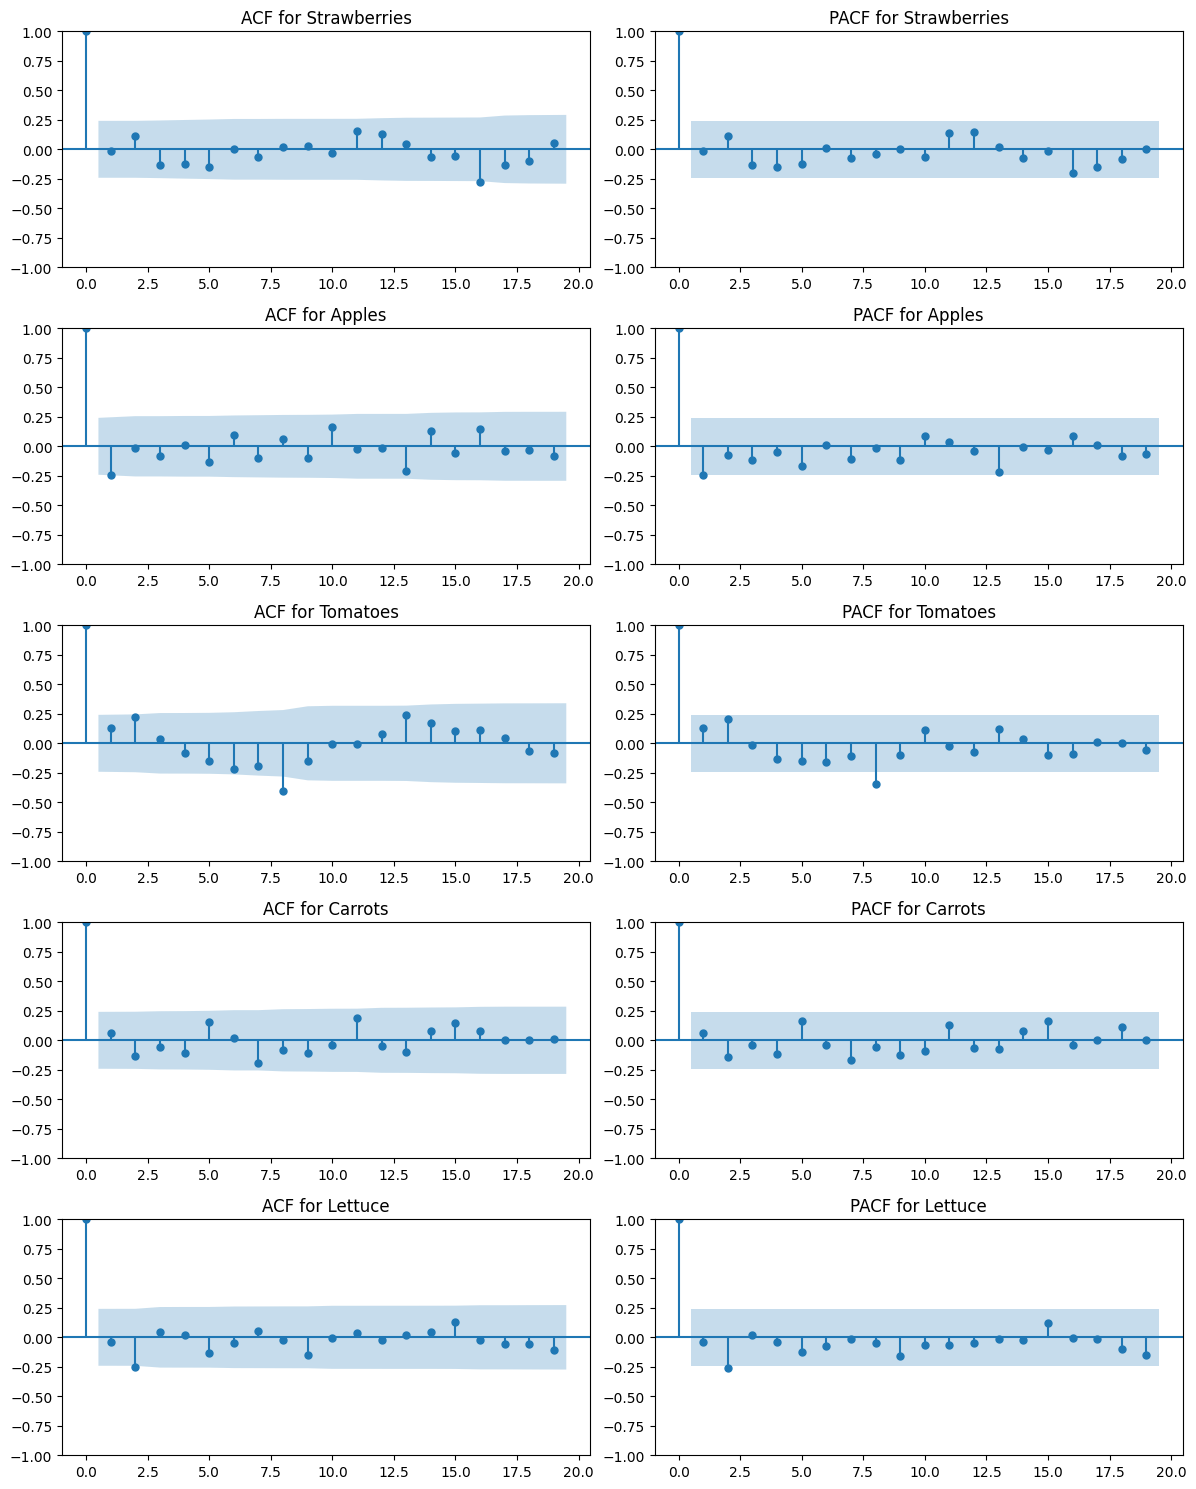

In [ ]:
# Get total number of products
n_products = len(products)

fig, ax = plt.subplots(n_products, 2, figsize=(12, 15))

for i in range(n_products):
    product = products[i]

    # Get the subset for the product
    product_data = pd.concat([train_data[product], test_data[product]])

    # Plot the ACF for that product
    acf_plot = plot_acf(product_data['Quantity_Sold'],
                        ax=ax[i][0],
                        title=f'ACF for {product}')

    # Plot the PACF for that product
    acf_plot = plot_pacf(product_data['Quantity_Sold'],
                         ax=ax[i][1],
                         title=f'PACF for {product}')

plt.tight_layout()
plt.show()

From the plots, a few things are clear:
- The **MA** value, which is gotten from the ACF plot can be taken as 1, at the point where the spike decays,
- The **AR** value, which is gotten from the PACF plot can be taken as 1 also, at the point were the spike decays.
- The degree of differencing is 0, since we didn't have to do any differencing in order to get a stationary data, because it was already stationarity.

Next, we build the ARIMA model for each product category.

In [ ]:
# Store metrics
mae, rmse, mape = 0, 0, 0
arima_mape_scores = dict()

# Store forecasts for plotting later
arima_forecasts = dict()

for product in products:

    # Get train and test data
    train = train_data[product]['Quantity_Sold'].values
    test = test_data[product]['Quantity_Sold'].values

    # Fit the ARIMA model
    model = ARIMA(train, order=(1, 0, 1)) # order = MA, differecing, AR values
    model_fit = model.fit()

    # Forecast on the test set
    forecast = model_fit.forecast(steps=len(test))

    # Store the forecast
    arima_forecasts[product] = forecast

    # Calculate MAE
    product_mae = mean_absolute_error(test, forecast)
    mae += product_mae

    # Calculate RMSE
    product_rmse = mean_squared_error(test, forecast, squared=False)
    rmse += product_rmse

    # Calculate MAPE
    product_mape = mean_absolute_percentage_error(test, forecast) * 100
    mape += product_mape

    arima_mape_scores[product] = product_mape

# Get the average of each score, to see the average metric for each product
mae /= n_products
rmse /= n_products
mape /= n_products

print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)

MAE: 4915.421944553493
RMSE: 6059.51600444451
MAPE: 9.971577746755546


With a MAPE score of **9.97%**, the model is a pretty OK model and may do quite well at making predictions for future sales quantity per product. But we cannot jump into conclusions without first seeing how the prediction works in comparison with the test data.

Now, let's visualize the train, test and forecasted data to really get a good glimpse of how this model is doing.

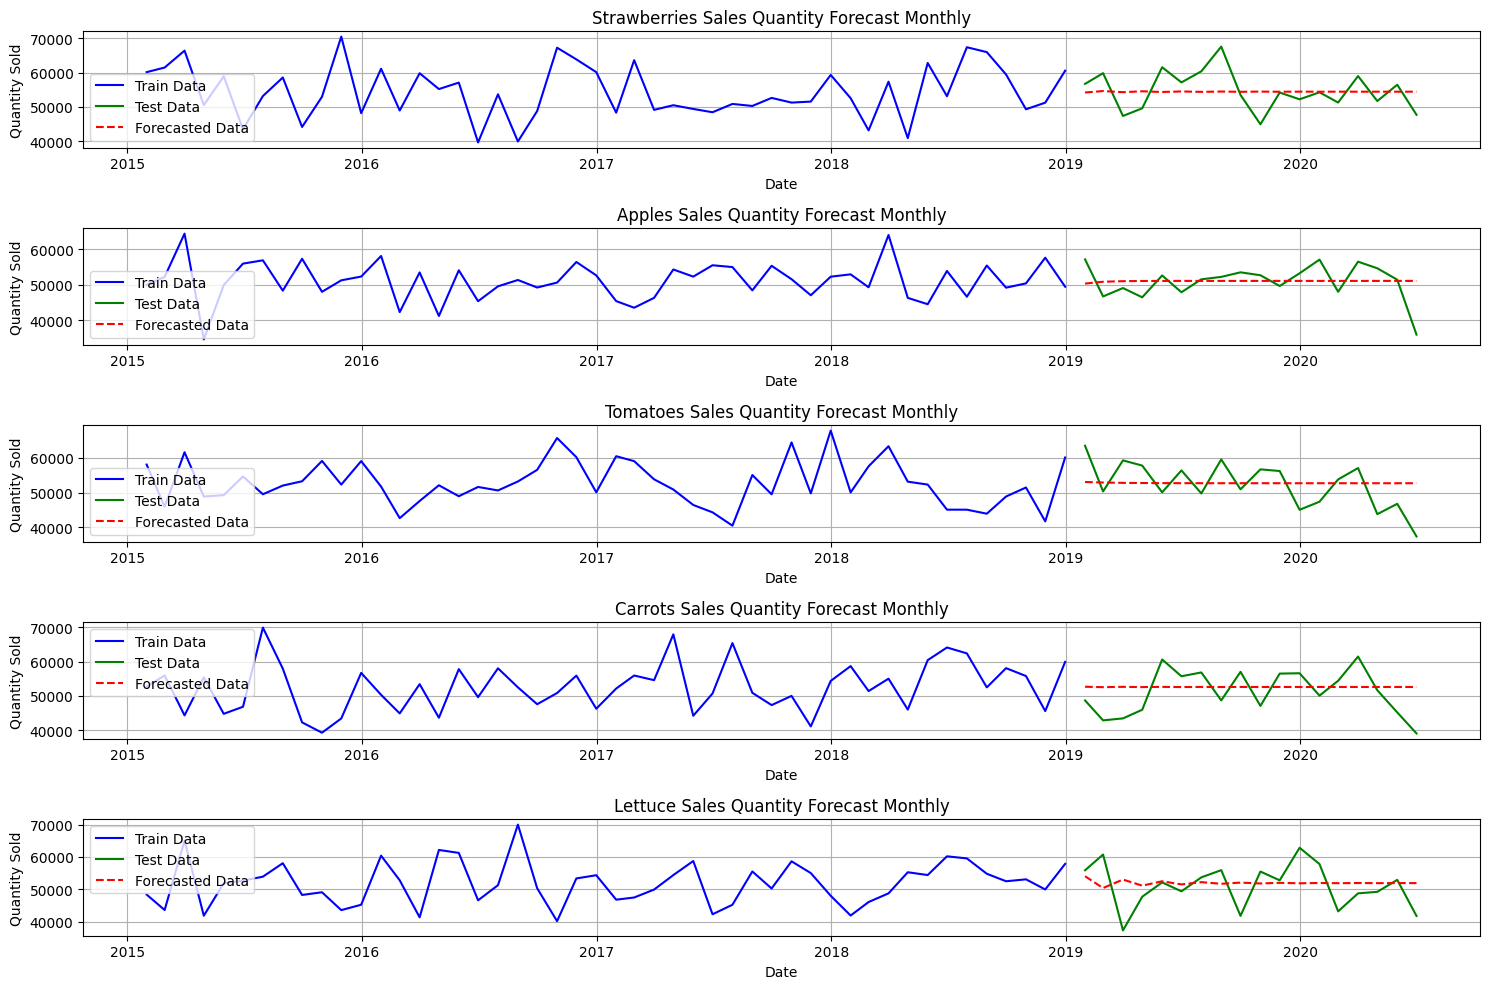

In [ ]:
plt.figure(figsize=(15, 10))

for i in range(n_products):
    product = products[i]

    plt.subplot(n_products, 1, i+1)

    # Plot train data
    plt.plot(train_data[product]['Date'],
             train_data[product]['Quantity_Sold'],
             label='Actual Quantity Sold (Train Data)',
             color='blue')

    # Plot test data
    plt.plot(test_data[product]['Date'],
             test_data[product]['Quantity_Sold'],
             label='Actual Quantity Sold (Test Data)',
             color='green')

    # Plot the forecasted data
    plt.plot(test_data[product]['Date'],
             arima_forecasts[product],
             label='Forecasted Quantity to be Sold',
             color='red',
             linestyle='--')

    plt.title(f'{product} Sales Quantity Forecast Monthly')
    plt.xlabel('Date')
    plt.ylabel('Quantity Sold')
    plt.legend(['Train Data', 'Test Data', 'Forecasted Data'])
    plt.grid(True)

plt.tight_layout()
plt.show()

As seen from the broken red line, the model almost to assumes a seemingly straight line in its forecast, this means that there may be no underlying pattern in the data that the odel can fit to easily.

#### Forecasting with Prophet

Here, we will be:
- training a `Prophet` model,
- using the `Prophet` model to forecast the weekly quantity sold,
- evaluating the `Prophet` on the MAE, RMSE, and MAPE scores.

In [ ]:
mae, rmse, mape = 0, 0, 0

# Dictionary to store the models themselves for later plotting
prophet_models = dict()

# Store the forecasts on the test set for later plotting
prophet_forecasts = dict()

# Dictionary to store the MAPE scores for later evaluatation in the end
prophet_mape_scores = dict()

for product in products:

    # Get train and test data
    train = train_data[product][['Date', 'Quantity_Sold']]
    test = test_data[product][['Date', 'Quantity_Sold']]

    # Rename the 'Date' and 'Quantity_Sold' columns to 'ds' and 'y' respectively
    # as required by Prophet model.
    train.columns = ['ds', 'y']
    test.columns = ['ds', 'y']

    # Initialize, fit and save Prophet model
    model_prophet = Prophet(yearly_seasonality=True, daily_seasonality=False)
    model_prophet.fit(train)
    prophet_models[product] = model_prophet

    # Create the dates to make predictions for
    future_dates = model_prophet.make_future_dataframe(periods=len(test), freq='M')

    # Forecast on the test set and store
    all_forecast = model_prophet.predict(future_dates)
    prophet_forecasts[product] = all_forecast

    test_forecast = all_forecast[-len(test):]

    # Calculate MAE
    product_mae = mean_absolute_error(test['y'], test_forecast['yhat'])
    mae += product_mae

    # Calculate RMSE
    product_rmse = mean_squared_error(test['y'], test_forecast['yhat'], squared=False)
    rmse += product_rmse

    # Calculate MAPE
    product_mape = mean_absolute_percentage_error(test['y'], test_forecast['yhat']) * 100
    mape += product_mape

    prophet_mape_scores[product] = product_mape

# Get the average of each score, to see the average metric for each product
mae /= n_products
rmse /= n_products
mape /= n_products

print('\nMAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)

08:24:42 - cmdstanpy - INFO - Chain [1] start processing
08:24:43 - cmdstanpy - INFO - Chain [1] done processing
08:24:44 - cmdstanpy - INFO - Chain [1] start processing
08:24:45 - cmdstanpy - INFO - Chain [1] done processing
08:24:45 - cmdstanpy - INFO - Chain [1] start processing
08:24:46 - cmdstanpy - INFO - Chain [1] done processing
08:24:47 - cmdstanpy - INFO - Chain [1] start processing
08:24:47 - cmdstanpy - INFO - Chain [1] done processing
08:24:48 - cmdstanpy - INFO - Chain [1] start processing
08:24:49 - cmdstanpy - INFO - Chain [1] done processing



MAE: 6557.378105160244
RMSE: 8136.561476450448
MAPE: 13.280853700065695


This model has a MAPE score of about 13.28%, this means the model is doing a bit worse than the ARIMA model. However, it is always best to visualize how good or how bad it is on a plot.

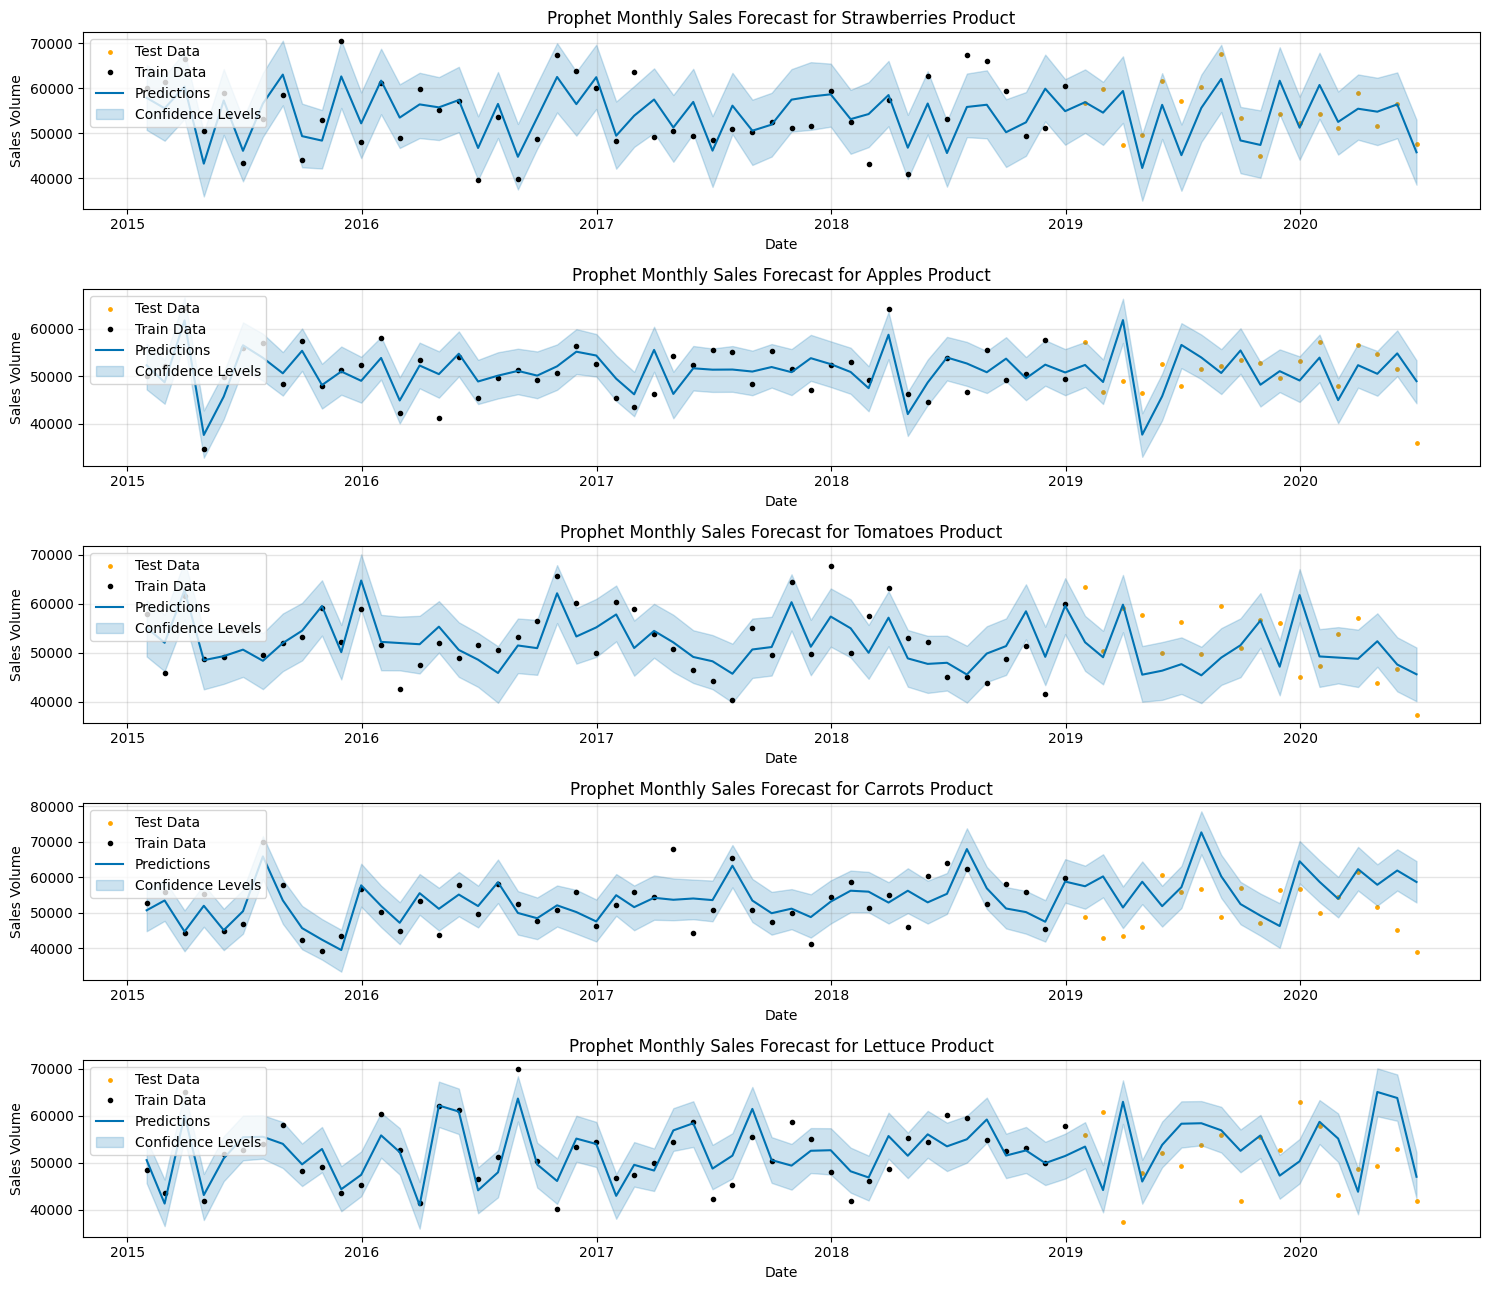

In [ ]:
# Create subplots to plot all category forecasts
fig, ax = plt.subplots(n_products, 1, figsize=(15, 13))

for i in range(n_products):
    product = products[i]

    # Plot the test data
    ax[i].scatter(test_data[product]['Date'],
                  test_data[product]['Quantity_Sold'],
                  color='orange',
                  s=6)

    # Plot the forecast and train data
    category_plot = prophet_models[product].plot(prophet_forecasts[product],
                                                 ax=ax[i],
                                                 figsize=(15, 7))

    ax[i].set_title(f'Prophet Monthly Sales Forecast for {product} Product')
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel('Sales Volume')

    ax[i].legend(['Test Data', 'Train Data', 'Predictions', 'Confidence Levels'],
                 loc='upper left')


plt.tight_layout()
plt.show()

As seen from the plot, the model is still an OK job at making predictions, the may mean that there aren't any easily identifiable underlying patterns in the dataset for the model to easily fit to.

#### Forecasting with RandomForestRegressor

Here, we will be using `RandomForestRegressor` to build a forecasting model for each of the products.

Because `RandomForestRegressor` is a different class of model from `ARIMA` and `Prophet`, we will have to do some preprocessing again first, before we can make use of it. But, it's still going to be a monthly forecast.

In [ ]:
mae, rmse, mape = 0, 0, 0

# Create the dictionary to store MAPE scores for later evaluation
rf_mape_scores = dict()

# Create dictionary to store train, test, and forecasted data
rf_X_train_dates = dict()
rf_y_train = dict()
rf_X_test_dates = dict()
rf_y_test = dict()
rf_forecasts = dict()

for product in products:

    # Separate the other products from the dataset
    df_product = df[df['Product'] == product]

    # Encode categorical data
    df_product = pd.get_dummies(df_product, drop_first=True)

    # Resample the data to a monthly frequency
    df_product = df_product.set_index('Date').resample('M').sum().reset_index()

    # Add features that describe the date
    df_product['Year'] = df_product['Date'].dt.year
    df_product['Month'] = df_product['Date'].dt.month
    df_product['Day'] = df_product['Date'].dt.day
    df_product['WeekOfYear'] = df_product['Date'].dt.isocalendar().week

    # Get and store the train and test sets for the product like we did before
    train = df_product[df_product['Year'] < 2019].reset_index()
    test = df_product[df_product['Year'] >= 2019].reset_index()

    # Store the data in multiple places
    rf_X_train_dates[product] = train['Date']
    rf_X_test_dates[product] = test['Date']

    # Remove the Date column, because it is already embeded in the other columns
    train = train.drop(columns=['Date'])
    test = test.drop(columns=['Date'])

    # Get X and y for the train set
    X_train = train.drop(columns=['Quantity_Sold', 'Revenue'])
    y_train = train['Quantity_Sold']

    # Get X and y for the test set
    X_test = test.drop(columns=['Quantity_Sold', 'Revenue'])
    y_test = test['Quantity_Sold']

    # Store date data in multiple places
    rf_y_train[product] = y_train
    rf_y_test[product] = y_test

    # Initialize and fit Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Forecast on the test set and store
    forecast = model.predict(X_test)
    rf_forecasts[product] = forecast

    # Calculate MAE
    product_mae = mean_absolute_error(y_test, forecast)
    mae += product_mae

    # Calculate RMSE
    product_rmse = mean_squared_error(y_test, forecast, squared=False)
    rmse += product_rmse

    # Calculate MAPE
    product_mape = mean_absolute_percentage_error(y_test, forecast) * 100
    mape += product_mape

    rf_mape_scores[product] = product_mape

# Get the average of each score, to see the average metric for each product
mae /= n_products
rmse /= n_products
mape /= n_products

print('\nMAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)



MAE: 2661.934684588824
RMSE: 3177.6926944638376
MAPE: 5.203538526320775


With a MAPE score of 5.2%, our model is performing extremely well. Let's now plot the results and see how well our model is performing.

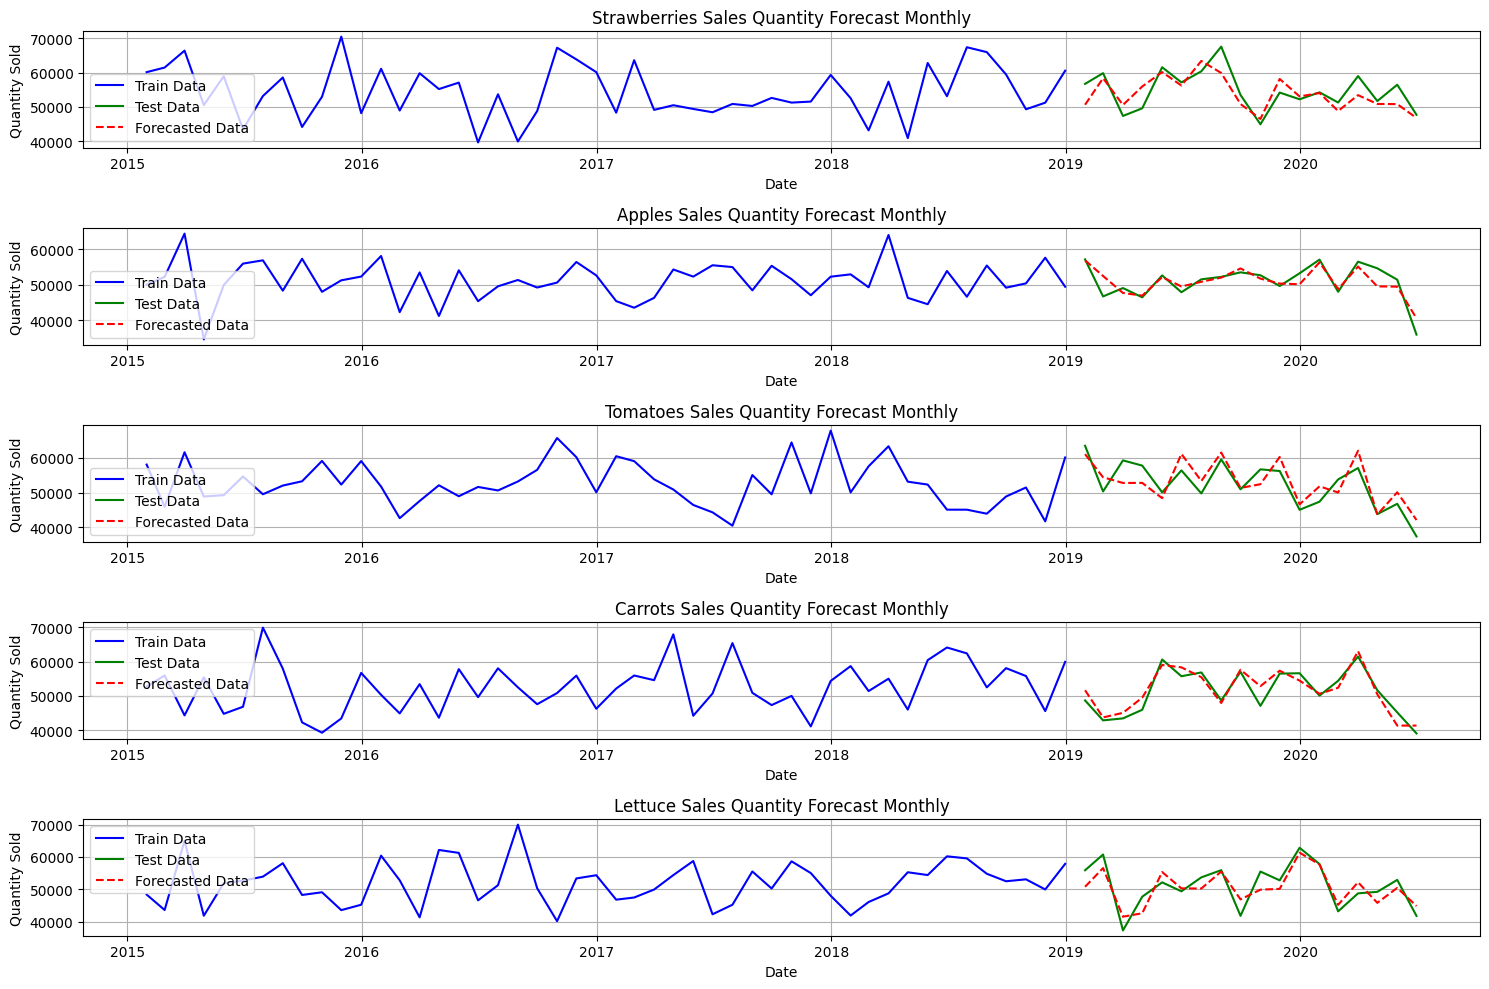

In [ ]:
plt.figure(figsize=(15, 10))

for i in range(n_products):
    product = products[i]

    plt.subplot(n_products, 1, i+1)

    # Plot train data
    plt.plot(rf_X_train_dates[product],
             rf_y_train[product],
             label='Actual Quantity Sold (Train Data)',
             color='blue')

    # Plot test data
    plt.plot(rf_X_test_dates[product],
             rf_y_test[product],
             label='Actual Quantity Sold (Test Data)',
             color='green')

    # Plot the forecasted data
    plt.plot(rf_X_test_dates[product],
             rf_forecasts[product],
             label='Forecasted Quantity to be Sold',
             color='red',
             linestyle='--')

    plt.title(f'{product} Sales Quantity Forecast Monthly')
    plt.xlabel('Date')
    plt.ylabel('Quantity Sold')
    plt.legend(['Train Data', 'Test Data', 'Forecasted Data'])
    plt.grid(True)

plt.tight_layout()
plt.show()

As seen in this plot, the model can forecast the quantity of goods sold monthly to a great amount of accuracy.

### Conclusion

Here, we will be looking at all the MAPE scores for all the models we have trained and see which one is best.

In [ ]:
# Get the average of all MAPE scores
arima_mape_scores['--Average--'] = np.mean([v for k, v in arima_mape_scores.items()])
prophet_mape_scores['--Average--'] = np.mean([v for k, v in prophet_mape_scores.items()])
rf_mape_scores['--Average--'] = np.mean([v for k, v in rf_mape_scores.items()])

# Convert the MAPE scores to a table for easy viewing
pd.DataFrame({'ARIMA': arima_mape_scores,
              'Prophet': prophet_mape_scores,
              'RandomForestRegressor': rf_mape_scores})

ARIMA    Prophet  RandomForestRegressor
Strawberries   8.252509   8.665478               5.482484
Apples         7.672138  10.521305               3.627103
Tomatoes      11.009154  12.012713               6.526076
Carrots       11.643824  18.719716               4.069554
Lettuce       11.280264  16.485058               6.312475
--Average--    9.971578  13.280854               5.203539

From the table:
- `RandomForestRegressor` had the best performance with an average MAPE score of 5.2%,
- `ARIMA` had the second best MAPE score with an average of 9.97%,
- `Prophet` had the worst MAPE score with an average of 13.28%,
- The most accurate product to predict was the `Strawberries`.
- The most difficulat product for the models to predict was `Carrots`.